<a href="https://colab.research.google.com/github/parthatom/UnsupervisedClassification/blob/master/UnSupervisedLearning_SyntheticData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Essentials


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def gini(array):
    """
    Calculate the Gini coefficient of a numpy array.
    """
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [0]:
import tqdm
from tqdm import tqdm

# Unsupervised Learning on Synthetic Sparse and Uniform Data

## Importing

In [0]:
import torch
import torchvision
import sys
import os
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path
import sklearn
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
colors = ['y', 'r']

In [0]:
def n_weight(x, db):
  xp = np.matmul(np.transpose(x), x)
  npow = xp * pow(10, -0.1*db)
  return npow.item()

In [0]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
class Metrics():
  def __init__(self):
    self.nmi = normalized_mutual_info_score
    self.ari = adjusted_rand_score


  def acc(self, y_true, y_pred):
      """
      Calculate clustering accuracy. Require scikit-learn installed
      # Arguments
          y: true labels, numpy.array with shape `(n_samples,)`
          y_pred: predicted labels, numpy.array with shape `(n_samples,)`
      # Return
          accuracy, in [0,1]
      """
      y_true = y_true.astype(np.int64)
      assert y_pred.size == y_true.size
      D = max(y_pred.max(), y_true.max()) + 1
      w = np.zeros((D, D), dtype=np.int64)
      for i in range(y_pred.size):
          w[y_pred[i], y_true[i]] += 1
      from sklearn.utils.linear_assignment_ import linear_assignment
      ind = linear_assignment(w.max() - w)
      return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [0]:
from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import mixture
import torchvision.transforms as transforms
from torchvision import models
from keras.utils import normalize
import time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import cv2
metrics = Metrics()

In [0]:
time.time()

1576493855.8468971

In [0]:
!mkdir /content/drive/'My Drive'/Outputs/Synthetic_Unsupervised/Sorted/gini

In [0]:
gmm_path = Path('/', 'content', 'drive', 'My Drive', 'Outputs','Synthetic_Unsupervised','Sorted', 'GMMs')
kmeans_path = Path('/', 'content', 'drive','My Drive', 'Outputs', 'Synthetic_Unsupervised','Sorted','KMeans')

In [0]:
synthetic_path = Path('/', 'content','drive', "My Drive", 'Outputs', 'Synthetic_Unsupervised','Sorted','gini')

## Data Creation

In [0]:
seed = 42
torch.random.manual_seed(seed)

### Sparse Data

In [0]:
# def Sparse(sparsity = 1, sensitivity = 1, db = 10):
#   print("Creating Sparse data")
#   perm1 = torch.randperm(39)
#   m =  torch.zeros((39,1))
#   for j in range(sparsity):
#     m[perm1[j].item()] = 1
#   # weight = n_weight(m.numpy(), db)  
#   weight = 1/sensitivity
#   m = m/torch.sum(m)
#   # m = nn.Softmax(dim = 0)(m)
#   m, c = torch.sort(m, dim = 0)
#   # print("initial ",gini(m.numpy()))
#   X = m
#   # print(X.shape)
#   perm1 = torch.randperm(39)
#   for i in range(5000):
#     m =  torch.zeros((39,1))
#     for j in range(sparsity):
#       m[perm1[j].item()] = 1
#     m = m/torch.sum(m)
#     noise = torch.randn_like(m)
#     # noise/=torch.max(noise)
#     noisy_m = torch.abs(m + weight *noise)
#     noisy_m/= torch.sum(noisy_m)
#     # noisy_m = nn.Softmax(dim = 0)(noisy_m)
#     noisy_m, c = torch.sort(noisy_m, dim = 0)
#     X = torch.cat((X,noisy_m), dim = 1)
#   X = X.T  
#   return X

### Uniform Data

In [0]:
# def uniform(sparsity =1, sensitivity = 1, db = 10):
#   print("Creating Uniform data")
#   perm1 = torch.randperm(39)
#   u =  torch.ones((39,1))
#   for j in range(sparsity-1):
#     u[perm1[j].item()] = 0
#   u = u/torch.sum(u)
#   # u = nn.Softmax(dim = 0)(u)
#   u, c = torch.sort(u, dim = 0)
#   # print("initial", gini(u.numpy()))
#   weight = 1/sensitivity
#   # weight = n_weight(u.numpy(), db=db)
#   X = u
#   for i in range(5000):
#     perm1 = torch.randperm(39)
#     u =  torch.ones((39,1))
#     for j in range(sparsity-1):
#       u[perm1[j].item()] = 0
#     u = u/torch.sum(u)
#     noise = torch.randn_like(u)
#     # noise/= (torch.max(noise))
#     noisy_u = torch.abs(u + weight*noise)
#     noisy_u/= torch.sum(noisy_u)
#     # noisy_u = nn.Softmax(dim = 0)(noisy_u)
#     noisy_u, c = torch.sort(noisy_u, dim = 0)
#     X = torch.cat((X,noisy_u), dim = 1)
#   X = X.T
#   return X

### Concat and Shuffle

In [0]:
def synth_data(sparsity = 1, std =  0.01, sparse = True):
  perm1 = torch.randperm(39)
  if(sparse):
    print("Creating Sparse Data")
    X = torch.zeros((1,39))
    for i in range(sparsity):
      X[0][int(perm1[i].item())] = 1
  else:
    print("Creating Uniform data")
    X = torch.ones((1, 39))
    for i in range(sparsity-1):
      X[0][int(perm1[i].item())] = 0
  # X,c = torch.sort(X, dim = 0)
  noise = torch.randn((5001,39))
  noisy_X = X+ std*noise
  noisy_X = torch.abs(noisy_X)
  noisy_X = noisy_X/(torch.sum(noisy_X, dim = 1).view(-1,1))
  noisy_X, c = torch.sort(noisy_X, dim = 1)
  return noisy_X

In [0]:
def create_data(sparsity = 1, std = 0.01):
  un = synth_data(sparsity= sparsity, std = std, sparse = False)
  sp = synth_data(sparsity = sparsity, std = std, sparse = True)
  X = torch.cat((un,sp), dim = 0)
  o = torch.ones((5001,1))
  z = torch.zeros((5001,1))
  labels = torch.cat((o,z), dim = 0)
  perm = torch.randperm(10002)
  X = X[perm]
  labels = labels[perm]
  return X, labels

In [0]:
# def create_data(sparsity = 1, sensitivity = 1, db = 10):
#   uni = uniform(sparsity = sparsity, sensitivity = sensitivity, db = db)
#   sparse = Sparse(sparsity=sparsity, sensitivity = sensitivity, db = db)
#   X = torch.cat((uni,sparse), dim = 0)
#   perm = torch.randperm(10002)
#   o = torch.ones((5001,1)) # Ones for uniform
#   z = torch.zeros((5001,1)) # Zeros for Sparse
#   labels = torch.cat((o,z), dim = 0)
#   labels = labels[perm]
#   X=X[perm]
#   return X, labels

In [0]:
a = create_data(sparsity = 1, std = 0.01)
X = a[0]
labels = a[1]
# np.save(os.path.join(synthetic_path, 'X.npy'), X)
# np.save(os.path.join(synthetic_path, 'y.npy'), labels)
print(X.shape)
print([(gini(X[i].numpy()),i) for i in range(600, 604)])
print(X[600:604])
labels[600:604]

Creating Uniform data
Creating Sparse Data
torch.Size([10002, 39])
[(0.006747550357785449, 600), (0.006538455482499899, 601), (0.8566153292129629, 602), (0.8495978218964907, 603)]
tensor([[2.5101e-02, 2.5122e-02, 2.5164e-02, 2.5195e-02, 2.5202e-02, 2.5224e-02,
         2.5290e-02, 2.5389e-02, 2.5424e-02, 2.5460e-02, 2.5490e-02, 2.5517e-02,
         2.5521e-02, 2.5525e-02, 2.5529e-02, 2.5536e-02, 2.5539e-02, 2.5559e-02,
         2.5608e-02, 2.5641e-02, 2.5663e-02, 2.5689e-02, 2.5694e-02, 2.5706e-02,
         2.5730e-02, 2.5734e-02, 2.5748e-02, 2.5751e-02, 2.5766e-02, 2.5875e-02,
         2.5909e-02, 2.5958e-02, 2.5961e-02, 2.5994e-02, 2.5996e-02, 2.6051e-02,
         2.6193e-02, 2.6244e-02, 2.6301e-02],
        [2.4976e-02, 2.5185e-02, 2.5185e-02, 2.5253e-02, 2.5328e-02, 2.5333e-02,
         2.5339e-02, 2.5381e-02, 2.5420e-02, 2.5444e-02, 2.5466e-02, 2.5469e-02,
         2.5494e-02, 2.5520e-02, 2.5522e-02, 2.5549e-02, 2.5570e-02, 2.5583e-02,
         2.5598e-02, 2.5599e-02, 2.5639e-02, 

tensor([[1.],
        [1.],
        [0.],
        [0.]])

## GMMs

### Model

In [0]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
cmap = plt.get_cmap('gnuplot')
colors = ['y', 'r']
%matplotlib inline

In [0]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input, BatchNormalization
from keras.models import Model
from keras.optimizers import SGD,Adam
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
metrics = Metrics()

Using TensorFlow backend.


In [0]:
def Autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)
        x = BatchNormalization()(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)
        x = BatchNormalization()(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [0]:
n_clusters = 2

In [0]:
dims = [X.shape[-1], 500, 500, 2000, 2]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = Adam(lr=0.001 )
pretrain_epochs = 30
batch_size = 256
save_dir = synthetic_path

In [0]:
lrs = [3e-5, 2.25e-5, 1.68e-5, 1.27e-5, 1e-5 ]
batch_sizes = [64, 72, 82, 100, 113, 128]
epochs = [5, 5, 10, 10]

In [0]:
len(lrs)

6

In [0]:
accuracy_tuning = np.zeros((len(lrs), len(batch_sizes), len(epochs)))
loss_tuning = np.zeros((len(lrs), len(batch_sizes), len(epochs)))
accuracy_tuning.shape

(6, 5, 4)

In [0]:
db = 9
X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_db_{db}.npy'))
y = np.load(os.path.join(synthetic_path, f"labels_sparsity_1_db_{db}.npy"))

In [0]:
history_list = []
for i,lr in enumerate(lrs):
  for j,batch_size in enumerate(batch_sizes):
    autoencoder, encoder = Autoencoder(dims, init=init)
    pretrain_optimizer = Adam(lr=lr)    
    autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
    
    for k,pretrain_epochs in enumerate(epochs): 
      total_trained = 0     
      b = autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
      history_list.append(b)
      loss_tuning[i][j][k] = (b.history['loss'])[-1]
      autoencoder.save_weights(os.path.join(synthetic_path, f"ae_sparsity_1_db_{db}_lr_{lr}_batch_size_{batch_size}_epochs_{pretrain_epochs+total_trained}.h5"))
      total_trained = pretrain_epochs
      encoding = encoder.predict(X)      

      kmeans = KMeans(n_clusters=2, n_init = 15).fit(encoding)
      y_pred_ae_means = kmeans.labels_
      del kmeans

      accs_ae_means = metrics.acc(y.reshape(10002,), y_pred_ae_means.reshape(10002,))
      print("accuracy",lr,batch_size, pretrain_epochs, accs_ae_means)
      accuracy_tuning[i][j][k] = accs_ae_means
      del y_pred_ae_means, accs_ae_means
    del autoencoder, encoder, pretrain_optimizer
np.save(os.path.join(synthetic_path, f'accuracy_tuning_sparsity_1_db_{db}.npy'), accuracy_tuning)
np.save(os.path.join(synthetic_path, f'loss_tuning_sparsity_1_db_{db}.npy'), loss_tuning)

Epoch 1/5
10002/10002 [==============================] - 5s 539us/step - loss: 5.1476
Epoch 2/5
10002/10002 [==============================] - 2s 190us/step - loss: 1.9483
Epoch 3/5
10002/10002 [==============================] - 2s 189us/step - loss: 17.4199
Epoch 4/5
10002/10002 [==============================] - 2s 193us/step - loss: 2.9698
Epoch 5/5
10002/10002 [==============================] - 2s 190us/step - loss: 5.5499
accuracy 0.001 64 5 0.5002999400119976
Epoch 1/5
  960/10002 [=>............................] - ETA: 1s - loss: 5.6777

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 193us/step - loss: 7.9502
Epoch 2/5
10002/10002 [==============================] - 2s 189us/step - loss: 2.8986
Epoch 3/5
10002/10002 [==============================] - 2s 192us/step - loss: 2.2998
Epoch 4/5
10002/10002 [==============================] - 2s 190us/step - loss: 6.2516
Epoch 5/5
10002/10002 [==============================] - 2s 186us/step - loss: 4.0056
accuracy 0.001 64 5 0.5000999800039992
Epoch 1/10
 1024/10002 [==>...........................] - ETA: 1s - loss: 0.3172

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 186us/step - loss: 3.9855
Epoch 2/10
10002/10002 [==============================] - 2s 186us/step - loss: 8.2508
Epoch 3/10
10002/10002 [==============================] - 2s 189us/step - loss: 3.0167
Epoch 4/10
10002/10002 [==============================] - 2s 189us/step - loss: 3.0098
Epoch 5/10
10002/10002 [==============================] - 2s 186us/step - loss: 6.2881
Epoch 6/10
10002/10002 [==============================] - 2s 186us/step - loss: 2.9774
Epoch 7/10
10002/10002 [==============================] - 2s 187us/step - loss: 4.8679
Epoch 8/10
10002/10002 [==============================] - 2s 187us/step - loss: 4.3436
Epoch 9/10
10002/10002 [==============================] - 2s 185us/step - loss: 5.3614
Epoch 10/10
10002/10002 [==============================] - 2s 185us/step - loss: 2.4700
accuracy 0.001 64 10 0.5000999800039992
Epoch 1/10
 1024/10002 [==>...........................] - ETA: 1s - loss: 0.0678

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 185us/step - loss: 2.1148
Epoch 2/10
10002/10002 [==============================] - 2s 181us/step - loss: 6.5122
Epoch 3/10
10002/10002 [==============================] - 2s 185us/step - loss: 11.6277
Epoch 4/10
10002/10002 [==============================] - 2s 183us/step - loss: 2.9783
Epoch 5/10
10002/10002 [==============================] - 2s 187us/step - loss: 5.5326
Epoch 6/10
10002/10002 [==============================] - 2s 185us/step - loss: 3.4699
Epoch 7/10
10002/10002 [==============================] - 2s 181us/step - loss: 3.1338
Epoch 8/10
10002/10002 [==============================] - 2s 182us/step - loss: 5.4475
Epoch 9/10
10002/10002 [==============================] - 2s 183us/step - loss: 2.2405
Epoch 10/10
10002/10002 [==============================] - 2s 185us/step - loss: 2.3303


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 64 10 0.8563287342531494
Epoch 1/5
10002/10002 [==============================] - 5s 501us/step - loss: 3.5802
Epoch 2/5
10002/10002 [==============================] - 1s 132us/step - loss: 2.7311
Epoch 3/5
10002/10002 [==============================] - 1s 132us/step - loss: 1.3805
Epoch 4/5
10002/10002 [==============================] - 1s 131us/step - loss: 1.6555
Epoch 5/5
10002/10002 [==============================] - 1s 131us/step - loss: 4.0429
accuracy 0.001 100 5 0.5000999800039992
Epoch 1/5
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.6069

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 129us/step - loss: 4.4131
Epoch 2/5
10002/10002 [==============================] - 1s 125us/step - loss: 13.9886
Epoch 3/5
10002/10002 [==============================] - 1s 124us/step - loss: 9.4652
Epoch 4/5
10002/10002 [==============================] - 1s 121us/step - loss: 3.1341
Epoch 5/5
10002/10002 [==============================] - 1s 122us/step - loss: 3.1563
accuracy 0.001 100 5 0.5000999800039992
Epoch 1/10
 1600/10002 [===>..........................] - ETA: 1s - loss: 2.2544

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 124us/step - loss: 6.1908
Epoch 2/10
10002/10002 [==============================] - 1s 123us/step - loss: 3.8082
Epoch 3/10
10002/10002 [==============================] - 1s 120us/step - loss: 7.4347
Epoch 4/10
10002/10002 [==============================] - 1s 121us/step - loss: 5.0317
Epoch 5/10
10002/10002 [==============================] - 1s 122us/step - loss: 3.4087
Epoch 6/10
10002/10002 [==============================] - 1s 120us/step - loss: 1.6146
Epoch 7/10
10002/10002 [==============================] - 1s 120us/step - loss: 10.1643
Epoch 8/10
10002/10002 [==============================] - 1s 122us/step - loss: 2.4883
Epoch 9/10
10002/10002 [==============================] - 1s 122us/step - loss: 3.3685
Epoch 10/10
10002/10002 [==============================] - 1s 120us/step - loss: 21.1108
accuracy 0.001 100 10 0.5002999400119976
Epoch 1/10
 1600/10002 [===>..........................] - ETA: 0s - loss: 0.5773

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 120us/step - loss: 12.2358
Epoch 2/10
10002/10002 [==============================] - 1s 122us/step - loss: 4.5933
Epoch 3/10
10002/10002 [==============================] - 1s 120us/step - loss: 4.0563
Epoch 4/10
10002/10002 [==============================] - 1s 121us/step - loss: 3.6605
Epoch 5/10
10002/10002 [==============================] - 1s 120us/step - loss: 2.7908
Epoch 6/10
10002/10002 [==============================] - 1s 120us/step - loss: 2.9345
Epoch 7/10
10002/10002 [==============================] - 1s 121us/step - loss: 0.8993
Epoch 8/10
10002/10002 [==============================] - 1s 123us/step - loss: 7.2143
Epoch 9/10
10002/10002 [==============================] - 1s 122us/step - loss: 4.1528
Epoch 10/10
10002/10002 [==============================] - 1s 120us/step - loss: 2.8620


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 100 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 5s 488us/step - loss: 4.1859
Epoch 2/5
10002/10002 [==============================] - 1s 106us/step - loss: 2.8959
Epoch 3/5
10002/10002 [==============================] - 1s 105us/step - loss: 2.4828
Epoch 4/5
10002/10002 [==============================] - 1s 103us/step - loss: 1.2556
Epoch 5/5
10002/10002 [==============================] - 1s 104us/step - loss: 1.5027
accuracy 0.001 128 5 0.5000999800039992
Epoch 1/5
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.5220

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 104us/step - loss: 2.2750
Epoch 2/5
10002/10002 [==============================] - 1s 104us/step - loss: 1.9106
Epoch 3/5
10002/10002 [==============================] - 1s 104us/step - loss: 2.0959
Epoch 4/5
10002/10002 [==============================] - 1s 106us/step - loss: 4.8123
Epoch 5/5
10002/10002 [==============================] - 1s 105us/step - loss: 5.2234
accuracy 0.001 128 5 0.5002999400119976
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.1544

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 106us/step - loss: 1.6976
Epoch 2/10
10002/10002 [==============================] - 1s 104us/step - loss: 5.3932
Epoch 3/10
10002/10002 [==============================] - 1s 102us/step - loss: 3.2467
Epoch 4/10
10002/10002 [==============================] - 1s 103us/step - loss: 2.5767
Epoch 5/10
10002/10002 [==============================] - 1s 102us/step - loss: 5.7876
Epoch 6/10
10002/10002 [==============================] - 1s 101us/step - loss: 4.4006
Epoch 7/10
10002/10002 [==============================] - 1s 101us/step - loss: 4.7237
Epoch 8/10
10002/10002 [==============================] - 1s 100us/step - loss: 1.8495
Epoch 9/10
10002/10002 [==============================] - 1s 97us/step - loss: 1.5437
Epoch 10/10
10002/10002 [==============================] - 1s 97us/step - loss: 3.6781
accuracy 0.001 128 10 0.5000999800039992
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.5682

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 100us/step - loss: 2.3125
Epoch 2/10
10002/10002 [==============================] - 1s 99us/step - loss: 4.0714
Epoch 3/10
10002/10002 [==============================] - 1s 97us/step - loss: 5.3431
Epoch 4/10
10002/10002 [==============================] - 1s 98us/step - loss: 2.0094
Epoch 5/10
10002/10002 [==============================] - 1s 98us/step - loss: 6.4210
Epoch 6/10
10002/10002 [==============================] - 1s 97us/step - loss: 5.5515
Epoch 7/10
10002/10002 [==============================] - 1s 97us/step - loss: 5.6611
Epoch 8/10
10002/10002 [==============================] - 1s 99us/step - loss: 6.7062
Epoch 9/10
10002/10002 [==============================] - 1s 99us/step - loss: 3.1013
Epoch 10/10
10002/10002 [==============================] - 1s 99us/step - loss: 6.5138


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 128 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 4s 447us/step - loss: 5.7861
Epoch 2/5
10002/10002 [==============================] - 1s 55us/step - loss: 4.1741
Epoch 3/5
10002/10002 [==============================] - 1s 55us/step - loss: 3.5293
Epoch 4/5
10002/10002 [==============================] - 1s 55us/step - loss: 4.1741
Epoch 5/5
10002/10002 [==============================] - 1s 56us/step - loss: 4.3002
accuracy 0.001 256 5 0.5000999800039992
Epoch 1/5
 3328/10002 [========>.....................] - ETA: 0s - loss: 1.8445

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 54us/step - loss: 1.5173
Epoch 2/5
10002/10002 [==============================] - 1s 55us/step - loss: 2.3341
Epoch 3/5
10002/10002 [==============================] - 1s 53us/step - loss: 2.8372
Epoch 4/5
10002/10002 [==============================] - 1s 55us/step - loss: 2.4370
Epoch 5/5
10002/10002 [==============================] - 1s 53us/step - loss: 1.4404
accuracy 0.001 256 5 0.5000999800039992
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 9.8680 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 55us/step - loss: 6.2144
Epoch 2/10
10002/10002 [==============================] - 1s 54us/step - loss: 3.5365
Epoch 3/10
10002/10002 [==============================] - 1s 55us/step - loss: 3.1616
Epoch 4/10
10002/10002 [==============================] - 1s 54us/step - loss: 2.3058
Epoch 5/10
10002/10002 [==============================] - 1s 54us/step - loss: 1.3157
Epoch 6/10
10002/10002 [==============================] - 1s 53us/step - loss: 7.5054
Epoch 7/10
10002/10002 [==============================] - 1s 54us/step - loss: 3.1785
Epoch 8/10
10002/10002 [==============================] - 1s 52us/step - loss: 6.7023
Epoch 9/10
10002/10002 [==============================] - 1s 56us/step - loss: 9.3084
Epoch 10/10
10002/10002 [==============================] - 1s 53us/step - loss: 5.5210
accuracy 0.001 256 10 0.5000999800039992
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 1.6775

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 52us/step - loss: 4.0004
Epoch 2/10
10002/10002 [==============================] - 1s 52us/step - loss: 5.3757
Epoch 3/10
10002/10002 [==============================] - 1s 53us/step - loss: 2.6588
Epoch 4/10
10002/10002 [==============================] - 1s 53us/step - loss: 2.2372
Epoch 5/10
10002/10002 [==============================] - 1s 54us/step - loss: 2.7328
Epoch 6/10
10002/10002 [==============================] - 1s 53us/step - loss: 26.3517
Epoch 7/10
10002/10002 [==============================] - 1s 54us/step - loss: 3.8042
Epoch 8/10
10002/10002 [==============================] - 1s 53us/step - loss: 3.4125
Epoch 9/10
10002/10002 [==============================] - 1s 56us/step - loss: 4.0881
Epoch 10/10
10002/10002 [==============================] - 1s 53us/step - loss: 2.1516


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 256 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 4s 440us/step - loss: 3.1038
Epoch 2/5
10002/10002 [==============================] - 0s 31us/step - loss: 3.6060
Epoch 3/5
10002/10002 [==============================] - 0s 33us/step - loss: 1.7704
Epoch 4/5
10002/10002 [==============================] - 0s 30us/step - loss: 3.3429
Epoch 5/5
10002/10002 [==============================] - 0s 31us/step - loss: 1.8747
accuracy 0.001 512 5 0.5000999800039992
Epoch 1/5
 6656/10002 [==================>...........] - ETA: 0s - loss: 0.4619

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 30us/step - loss: 1.1304
Epoch 2/5
10002/10002 [==============================] - 0s 30us/step - loss: 2.5211
Epoch 3/5
10002/10002 [==============================] - 0s 31us/step - loss: 4.4737
Epoch 4/5
10002/10002 [==============================] - 0s 31us/step - loss: 1.3035
Epoch 5/5
10002/10002 [==============================] - 0s 31us/step - loss: 2.3376
accuracy 0.001 512 5 0.5001999600079984
Epoch 1/10
 6656/10002 [==================>...........] - ETA: 0s - loss: 3.9036

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 30us/step - loss: 2.7227
Epoch 2/10
10002/10002 [==============================] - 0s 31us/step - loss: 2.4529
Epoch 3/10
10002/10002 [==============================] - 0s 30us/step - loss: 3.6247
Epoch 4/10
10002/10002 [==============================] - 0s 30us/step - loss: 1.7085
Epoch 5/10
10002/10002 [==============================] - 0s 31us/step - loss: 4.5984
Epoch 6/10
10002/10002 [==============================] - 0s 30us/step - loss: 2.9294
Epoch 7/10
10002/10002 [==============================] - 0s 31us/step - loss: 4.6362
Epoch 8/10
10002/10002 [==============================] - 0s 31us/step - loss: 2.3980
Epoch 9/10
10002/10002 [==============================] - 0s 31us/step - loss: 2.8366
Epoch 10/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.7335
accuracy 0.001 512 10 0.5002999400119976
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 3.3092

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 31us/step - loss: 2.5691
Epoch 2/10
10002/10002 [==============================] - 0s 30us/step - loss: 6.2054
Epoch 3/10
10002/10002 [==============================] - 0s 30us/step - loss: 4.4079
Epoch 4/10
10002/10002 [==============================] - 0s 31us/step - loss: 2.6303
Epoch 5/10
10002/10002 [==============================] - 0s 33us/step - loss: 3.0116
Epoch 6/10
10002/10002 [==============================] - 0s 30us/step - loss: 2.8411
Epoch 7/10
10002/10002 [==============================] - 0s 30us/step - loss: 4.8035
Epoch 8/10
10002/10002 [==============================] - 0s 31us/step - loss: 2.3236
Epoch 9/10
10002/10002 [==============================] - 0s 31us/step - loss: 3.9155
Epoch 10/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.9600


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.001 512 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 6s 612us/step - loss: 3.0284
Epoch 2/5
10002/10002 [==============================] - 2s 200us/step - loss: 1.9513
Epoch 3/5
10002/10002 [==============================] - 2s 199us/step - loss: 0.6599
Epoch 4/5
10002/10002 [==============================] - 2s 198us/step - loss: 0.5142
Epoch 5/5
10002/10002 [==============================] - 2s 201us/step - loss: 0.7298
accuracy 0.0001 64 5 0.5000999800039992
Epoch 1/5
  960/10002 [=>............................] - ETA: 1s - loss: 0.1113

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 199us/step - loss: 0.3660
Epoch 2/5
10002/10002 [==============================] - 2s 201us/step - loss: 1.3083
Epoch 3/5
10002/10002 [==============================] - 2s 201us/step - loss: 0.8711
Epoch 4/5
10002/10002 [==============================] - 2s 203us/step - loss: 1.1234
Epoch 5/5
10002/10002 [==============================] - 2s 200us/step - loss: 1.6534
accuracy 0.0001 64 5 0.5000999800039992
Epoch 1/10
  960/10002 [=>............................] - ETA: 1s - loss: 0.3301

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 198us/step - loss: 1.7823
Epoch 2/10
10002/10002 [==============================] - 2s 196us/step - loss: 0.1383
Epoch 3/10
10002/10002 [==============================] - 2s 197us/step - loss: 0.1843
Epoch 4/10
10002/10002 [==============================] - 2s 197us/step - loss: 6.4776
Epoch 5/10
10002/10002 [==============================] - 2s 200us/step - loss: 0.1845
Epoch 6/10
10002/10002 [==============================] - 2s 196us/step - loss: 0.5713
Epoch 7/10
10002/10002 [==============================] - 2s 197us/step - loss: 1.4303
Epoch 8/10
10002/10002 [==============================] - 2s 199us/step - loss: 0.3186
Epoch 9/10
10002/10002 [==============================] - 2s 195us/step - loss: 0.2210
Epoch 10/10
10002/10002 [==============================] - 2s 198us/step - loss: 0.2947
accuracy 0.0001 64 10 0.5000999800039992
Epoch 1/10
  896/10002 [=>............................] - ETA: 1s - loss: 0.0267

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 197us/step - loss: 0.0804
Epoch 2/10
10002/10002 [==============================] - 2s 197us/step - loss: 0.5259
Epoch 3/10
10002/10002 [==============================] - 2s 200us/step - loss: 0.3558
Epoch 4/10
10002/10002 [==============================] - 2s 201us/step - loss: 0.4365
Epoch 5/10
10002/10002 [==============================] - 2s 200us/step - loss: 0.5171
Epoch 6/10
10002/10002 [==============================] - 2s 203us/step - loss: 0.8530
Epoch 7/10
10002/10002 [==============================] - 2s 201us/step - loss: 0.4956
Epoch 8/10
10002/10002 [==============================] - 2s 199us/step - loss: 0.3591
Epoch 9/10
10002/10002 [==============================] - 2s 193us/step - loss: 2.1005
Epoch 10/10
10002/10002 [==============================] - 2s 197us/step - loss: 0.5412


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 64 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 6s 572us/step - loss: 5.9887
Epoch 2/5
10002/10002 [==============================] - 1s 137us/step - loss: 2.2326
Epoch 3/5
10002/10002 [==============================] - 1s 135us/step - loss: 1.6966
Epoch 4/5
10002/10002 [==============================] - 1s 131us/step - loss: 1.4036
Epoch 5/5
10002/10002 [==============================] - 1s 132us/step - loss: 0.4133
accuracy 0.0001 100 5 0.5000999800039992
Epoch 1/5
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.4887

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 130us/step - loss: 1.4430
Epoch 2/5
10002/10002 [==============================] - 1s 131us/step - loss: 1.0413
Epoch 3/5
10002/10002 [==============================] - 1s 135us/step - loss: 0.5020
Epoch 4/5
10002/10002 [==============================] - 1s 133us/step - loss: 1.9545
Epoch 5/5
10002/10002 [==============================] - 1s 132us/step - loss: 0.2253
accuracy 0.0001 100 5 0.5000999800039992
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.0125

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 131us/step - loss: 0.2310
Epoch 2/10
10002/10002 [==============================] - 1s 130us/step - loss: 0.9645
Epoch 3/10
10002/10002 [==============================] - 1s 130us/step - loss: 0.3444
Epoch 4/10
10002/10002 [==============================] - 1s 132us/step - loss: 2.2435
Epoch 5/10
10002/10002 [==============================] - 1s 129us/step - loss: 1.5487
Epoch 6/10
10002/10002 [==============================] - 1s 129us/step - loss: 0.8659
Epoch 7/10
10002/10002 [==============================] - 1s 130us/step - loss: 2.2683
Epoch 8/10
10002/10002 [==============================] - 1s 130us/step - loss: 1.3375
Epoch 9/10
10002/10002 [==============================] - 1s 131us/step - loss: 0.9898
Epoch 10/10
10002/10002 [==============================] - 1s 129us/step - loss: 0.4201
accuracy 0.0001 100 10 0.5000999800039992
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.0272

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 131us/step - loss: 0.3107
Epoch 2/10
10002/10002 [==============================] - 1s 129us/step - loss: 0.3615
Epoch 3/10
10002/10002 [==============================] - 1s 129us/step - loss: 1.7391
Epoch 4/10
10002/10002 [==============================] - 1s 129us/step - loss: 0.2819
Epoch 5/10
10002/10002 [==============================] - 1s 128us/step - loss: 1.5229
Epoch 6/10
10002/10002 [==============================] - 1s 127us/step - loss: 0.6410
Epoch 7/10
10002/10002 [==============================] - 1s 127us/step - loss: 0.2352
Epoch 8/10
10002/10002 [==============================] - 1s 126us/step - loss: 0.1203
Epoch 9/10
10002/10002 [==============================] - 1s 125us/step - loss: 1.1937
Epoch 10/10
10002/10002 [==============================] - 1s 126us/step - loss: 0.3061


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 100 10 0.5001999600079984
Epoch 1/5
10002/10002 [==============================] - 5s 549us/step - loss: 2.6797
Epoch 2/5
10002/10002 [==============================] - 1s 109us/step - loss: 1.6594
Epoch 3/5
10002/10002 [==============================] - 1s 107us/step - loss: 2.0372
Epoch 4/5
10002/10002 [==============================] - 1s 107us/step - loss: 0.9534
Epoch 5/5
10002/10002 [==============================] - 1s 107us/step - loss: 0.6474
accuracy 0.0001 128 5 0.5000999800039992
Epoch 1/5
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.2636

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 106us/step - loss: 0.3819
Epoch 2/5
10002/10002 [==============================] - 1s 107us/step - loss: 0.8305
Epoch 3/5
10002/10002 [==============================] - 1s 107us/step - loss: 0.5596
Epoch 4/5
10002/10002 [==============================] - 1s 106us/step - loss: 0.2924
Epoch 5/5
10002/10002 [==============================] - 1s 106us/step - loss: 0.2624
accuracy 0.0001 128 5 0.5000999800039992
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.0155

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 103us/step - loss: 0.2024
Epoch 2/10
10002/10002 [==============================] - 1s 105us/step - loss: 1.3172
Epoch 3/10
10002/10002 [==============================] - 1s 103us/step - loss: 3.4495
Epoch 4/10
10002/10002 [==============================] - 1s 105us/step - loss: 0.8217
Epoch 5/10
10002/10002 [==============================] - 1s 105us/step - loss: 1.1298
Epoch 6/10
10002/10002 [==============================] - 1s 104us/step - loss: 4.0577
Epoch 7/10
10002/10002 [==============================] - 1s 106us/step - loss: 5.5114
Epoch 8/10
10002/10002 [==============================] - 1s 105us/step - loss: 1.6124
Epoch 9/10
10002/10002 [==============================] - 1s 103us/step - loss: 0.9556
Epoch 10/10
10002/10002 [==============================] - 1s 103us/step - loss: 0.3592
accuracy 0.0001 128 10 0.5001999600079984
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 2.4515

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 102us/step - loss: 1.2675
Epoch 2/10
10002/10002 [==============================] - 1s 104us/step - loss: 0.1727
Epoch 3/10
10002/10002 [==============================] - 1s 103us/step - loss: 0.0729
Epoch 4/10
10002/10002 [==============================] - 1s 107us/step - loss: 0.1075
Epoch 5/10
10002/10002 [==============================] - 1s 105us/step - loss: 0.5240
Epoch 6/10
10002/10002 [==============================] - 1s 105us/step - loss: 0.4638
Epoch 7/10
10002/10002 [==============================] - 1s 105us/step - loss: 0.2242
Epoch 8/10
10002/10002 [==============================] - 1s 104us/step - loss: 0.6498
Epoch 9/10
10002/10002 [==============================] - 1s 104us/step - loss: 0.1435
Epoch 10/10
10002/10002 [==============================] - 1s 104us/step - loss: 0.0698


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 128 10 0.5001999600079984
Epoch 1/5
10002/10002 [==============================] - 5s 519us/step - loss: 5.6240
Epoch 2/5
10002/10002 [==============================] - 1s 58us/step - loss: 3.0853
Epoch 3/5
10002/10002 [==============================] - 1s 57us/step - loss: 1.7367
Epoch 4/5
10002/10002 [==============================] - 1s 56us/step - loss: 1.0849
Epoch 5/5
10002/10002 [==============================] - 1s 55us/step - loss: 3.5533
accuracy 0.0001 256 5 0.5001999600079984
Epoch 1/5
 3328/10002 [========>.....................] - ETA: 0s - loss: 7.4046 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 55us/step - loss: 2.6730
Epoch 2/5
10002/10002 [==============================] - 1s 56us/step - loss: 0.3144
Epoch 3/5
10002/10002 [==============================] - 1s 54us/step - loss: 0.3044
Epoch 4/5
10002/10002 [==============================] - 1s 55us/step - loss: 0.2003
Epoch 5/5
10002/10002 [==============================] - 1s 54us/step - loss: 0.0878
accuracy 0.0001 256 5 0.5000999800039992
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 0.2864

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 54us/step - loss: 0.2208
Epoch 2/10
10002/10002 [==============================] - 1s 54us/step - loss: 0.9177
Epoch 3/10
10002/10002 [==============================] - 1s 53us/step - loss: 0.1323
Epoch 4/10
10002/10002 [==============================] - 1s 53us/step - loss: 0.2550
Epoch 5/10
10002/10002 [==============================] - 1s 54us/step - loss: 0.1683
Epoch 6/10
10002/10002 [==============================] - 1s 53us/step - loss: 0.6897
Epoch 7/10
10002/10002 [==============================] - 1s 53us/step - loss: 0.1245
Epoch 8/10
10002/10002 [==============================] - 1s 53us/step - loss: 0.3574
Epoch 9/10
10002/10002 [==============================] - 1s 54us/step - loss: 0.2378
Epoch 10/10
10002/10002 [==============================] - 1s 54us/step - loss: 0.2317
accuracy 0.0001 256 10 0.5000999800039992
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 0.2683

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 53us/step - loss: 0.5389
Epoch 2/10
10002/10002 [==============================] - 1s 54us/step - loss: 2.8268
Epoch 3/10
10002/10002 [==============================] - 1s 53us/step - loss: 4.1550
Epoch 4/10
10002/10002 [==============================] - 1s 55us/step - loss: 0.3388
Epoch 5/10
10002/10002 [==============================] - 1s 53us/step - loss: 2.7430
Epoch 6/10
10002/10002 [==============================] - 1s 53us/step - loss: 0.3034
Epoch 7/10
10002/10002 [==============================] - 1s 52us/step - loss: 0.7418
Epoch 8/10
10002/10002 [==============================] - 1s 53us/step - loss: 0.1138
Epoch 9/10
10002/10002 [==============================] - 1s 53us/step - loss: 0.2795
Epoch 10/10
10002/10002 [==============================] - 1s 53us/step - loss: 0.3645


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 256 10 0.5001999600079984
Epoch 1/5
10002/10002 [==============================] - 5s 496us/step - loss: 6.2545
Epoch 2/5
10002/10002 [==============================] - 0s 33us/step - loss: 4.1877
Epoch 3/5
10002/10002 [==============================] - 0s 32us/step - loss: 2.4467
Epoch 4/5
10002/10002 [==============================] - 0s 30us/step - loss: 1.5762
Epoch 5/5
10002/10002 [==============================] - 0s 31us/step - loss: 1.2938
accuracy 0.0001 512 5 0.5000999800039992
Epoch 1/5
 3584/10002 [=========>....................] - ETA: 0s - loss: 0.2258

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 38us/step - loss: 1.1623
Epoch 2/5
10002/10002 [==============================] - 0s 33us/step - loss: 1.1648
Epoch 3/5
10002/10002 [==============================] - 0s 32us/step - loss: 0.8733
Epoch 4/5
10002/10002 [==============================] - 0s 31us/step - loss: 0.6341
Epoch 5/5
10002/10002 [==============================] - 0s 31us/step - loss: 0.3434
accuracy 0.0001 512 5 0.5000999800039992
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 0.0497

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 31us/step - loss: 0.6169
Epoch 2/10
10002/10002 [==============================] - 0s 31us/step - loss: 2.0336
Epoch 3/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.8014
Epoch 4/10
10002/10002 [==============================] - 0s 30us/step - loss: 1.0142
Epoch 5/10
10002/10002 [==============================] - 0s 30us/step - loss: 0.1871
Epoch 6/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.2673
Epoch 7/10
10002/10002 [==============================] - 0s 32us/step - loss: 0.1583
Epoch 8/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.3221
Epoch 9/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.3118
Epoch 10/10
10002/10002 [==============================] - 0s 30us/step - loss: 0.5399
accuracy 0.0001 512 10 0.5000999800039992
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 0.0372

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 31us/step - loss: 0.1682
Epoch 2/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.0460
Epoch 3/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.3910
Epoch 4/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.2079
Epoch 5/10
10002/10002 [==============================] - 0s 30us/step - loss: 0.3505
Epoch 6/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.2266
Epoch 7/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.2303
Epoch 8/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.0574
Epoch 9/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.0420
Epoch 10/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.0177


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0001 512 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 6s 642us/step - loss: 5.0464
Epoch 2/5
10002/10002 [==============================] - 2s 164us/step - loss: 1.3830
Epoch 3/5
10002/10002 [==============================] - 2s 165us/step - loss: 4.8738
Epoch 4/5
10002/10002 [==============================] - 2s 165us/step - loss: 0.7818
Epoch 5/5
10002/10002 [==============================] - 2s 163us/step - loss: 2.1685
accuracy 0.0003 64 5 0.5000999800039992
Epoch 1/5
  896/10002 [=>............................] - ETA: 1s - loss: 10.2250

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 168us/step - loss: 3.1878
Epoch 2/5
10002/10002 [==============================] - 2s 169us/step - loss: 3.7627
Epoch 3/5
10002/10002 [==============================] - 2s 169us/step - loss: 1.3028
Epoch 4/5
10002/10002 [==============================] - 2s 171us/step - loss: 2.7844
Epoch 5/5
10002/10002 [==============================] - 2s 166us/step - loss: 1.4788
accuracy 0.0003 64 5 0.5000999800039992
Epoch 1/10
 1024/10002 [==>...........................] - ETA: 1s - loss: 2.9326

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 166us/step - loss: 4.7667
Epoch 2/10
10002/10002 [==============================] - 2s 170us/step - loss: 1.9716
Epoch 3/10
10002/10002 [==============================] - 2s 174us/step - loss: 0.8368
Epoch 4/10
10002/10002 [==============================] - 2s 173us/step - loss: 1.2378
Epoch 5/10
10002/10002 [==============================] - 2s 173us/step - loss: 3.0127
Epoch 6/10
10002/10002 [==============================] - 2s 173us/step - loss: 1.3341
Epoch 7/10
10002/10002 [==============================] - 2s 176us/step - loss: 2.6322
Epoch 8/10
10002/10002 [==============================] - 2s 177us/step - loss: 2.2049
Epoch 9/10
10002/10002 [==============================] - 2s 179us/step - loss: 0.4159
Epoch 10/10
10002/10002 [==============================] - 2s 178us/step - loss: 1.1642
accuracy 0.0003 64 10 0.5002999400119976
Epoch 1/10
  960/10002 [=>............................] - ETA: 1s - loss: 0.9913

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 179us/step - loss: 3.3714
Epoch 2/10
10002/10002 [==============================] - 2s 179us/step - loss: 1.3503
Epoch 3/10
10002/10002 [==============================] - 2s 181us/step - loss: 2.6834
Epoch 4/10
10002/10002 [==============================] - 2s 179us/step - loss: 4.6178
Epoch 5/10
10002/10002 [==============================] - 2s 180us/step - loss: 2.6551
Epoch 6/10
10002/10002 [==============================] - 2s 179us/step - loss: 1.9836
Epoch 7/10
10002/10002 [==============================] - 2s 178us/step - loss: 0.7482
Epoch 8/10
10002/10002 [==============================] - 2s 178us/step - loss: 0.7986
Epoch 9/10
10002/10002 [==============================] - 2s 178us/step - loss: 3.7670
Epoch 10/10
10002/10002 [==============================] - 2s 178us/step - loss: 0.9589


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0003 64 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 6s 635us/step - loss: 3.2966
Epoch 2/5
10002/10002 [==============================] - 1s 137us/step - loss: 1.9728
Epoch 3/5
10002/10002 [==============================] - 1s 137us/step - loss: 0.9922
Epoch 4/5
10002/10002 [==============================] - 1s 139us/step - loss: 8.2267
Epoch 5/5
10002/10002 [==============================] - 1s 138us/step - loss: 2.1328
accuracy 0.0003 100 5 0.5000999800039992
Epoch 1/5
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.1357

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 137us/step - loss: 2.3079
Epoch 2/5
10002/10002 [==============================] - 1s 137us/step - loss: 0.4037
Epoch 3/5
10002/10002 [==============================] - 1s 140us/step - loss: 1.5574
Epoch 4/5
10002/10002 [==============================] - 1s 138us/step - loss: 1.1943
Epoch 5/5
10002/10002 [==============================] - 1s 140us/step - loss: 4.9955
accuracy 0.0003 100 5 0.5000999800039992
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.2265

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 140us/step - loss: 0.9679
Epoch 2/10
10002/10002 [==============================] - 1s 137us/step - loss: 2.5920
Epoch 3/10
10002/10002 [==============================] - 1s 137us/step - loss: 0.7646
Epoch 4/10
10002/10002 [==============================] - 1s 139us/step - loss: 0.2210
Epoch 5/10
10002/10002 [==============================] - 1s 136us/step - loss: 1.3883
Epoch 6/10
10002/10002 [==============================] - 1s 136us/step - loss: 1.4350
Epoch 7/10
10002/10002 [==============================] - 1s 137us/step - loss: 1.7509
Epoch 8/10
10002/10002 [==============================] - 1s 137us/step - loss: 0.9682
Epoch 9/10
10002/10002 [==============================] - 1s 136us/step - loss: 2.5194
Epoch 10/10
10002/10002 [==============================] - 1s 140us/step - loss: 1.0119
accuracy 0.0003 100 10 0.5000999800039992
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 5.4241

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 134us/step - loss: 2.2629
Epoch 2/10
10002/10002 [==============================] - 1s 137us/step - loss: 3.2630
Epoch 3/10
10002/10002 [==============================] - 1s 137us/step - loss: 1.0898
Epoch 4/10
10002/10002 [==============================] - 1s 137us/step - loss: 1.5850
Epoch 5/10
10002/10002 [==============================] - 1s 135us/step - loss: 2.9216
Epoch 6/10
10002/10002 [==============================] - 1s 134us/step - loss: 1.6706
Epoch 7/10
10002/10002 [==============================] - 1s 136us/step - loss: 5.4767
Epoch 8/10
10002/10002 [==============================] - 1s 135us/step - loss: 0.8501
Epoch 9/10
10002/10002 [==============================] - 1s 136us/step - loss: 1.7925
Epoch 10/10
10002/10002 [==============================] - 1s 140us/step - loss: 2.2598


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0003 100 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 6s 625us/step - loss: 2.7111
Epoch 2/5
10002/10002 [==============================] - 1s 116us/step - loss: 3.5375
Epoch 3/5
10002/10002 [==============================] - 1s 113us/step - loss: 2.9425
Epoch 4/5
10002/10002 [==============================] - 1s 113us/step - loss: 4.3292
Epoch 5/5
10002/10002 [==============================] - 1s 114us/step - loss: 4.3063
accuracy 0.0003 128 5 0.5000999800039992
Epoch 1/5
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.6661

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 112us/step - loss: 1.7198
Epoch 2/5
10002/10002 [==============================] - 1s 113us/step - loss: 14.2059
Epoch 3/5
10002/10002 [==============================] - 1s 111us/step - loss: 1.3264
Epoch 4/5
10002/10002 [==============================] - 1s 111us/step - loss: 0.3775
Epoch 5/5
10002/10002 [==============================] - 1s 112us/step - loss: 1.3238
accuracy 0.0003 128 5 0.5002999400119976
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 13.3202

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 111us/step - loss: 2.7227
Epoch 2/10
10002/10002 [==============================] - 1s 111us/step - loss: 1.3684
Epoch 3/10
10002/10002 [==============================] - 1s 113us/step - loss: 0.3788
Epoch 4/10
10002/10002 [==============================] - 1s 112us/step - loss: 30.3430
Epoch 5/10
10002/10002 [==============================] - 1s 112us/step - loss: 4.0286
Epoch 6/10
10002/10002 [==============================] - 1s 114us/step - loss: 2.0645
Epoch 7/10
10002/10002 [==============================] - 1s 111us/step - loss: 1.2726
Epoch 8/10
10002/10002 [==============================] - 1s 112us/step - loss: 0.6918
Epoch 9/10
10002/10002 [==============================] - 1s 110us/step - loss: 2.5105
Epoch 10/10
10002/10002 [==============================] - 1s 113us/step - loss: 0.8167
accuracy 0.0003 128 10 0.5000999800039992
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 1.2960

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 111us/step - loss: 0.5368
Epoch 2/10
10002/10002 [==============================] - 1s 112us/step - loss: 1.0572
Epoch 3/10
10002/10002 [==============================] - 1s 111us/step - loss: 0.4480
Epoch 4/10
10002/10002 [==============================] - 1s 113us/step - loss: 0.7483
Epoch 5/10
10002/10002 [==============================] - 1s 111us/step - loss: 1.1957
Epoch 6/10
10002/10002 [==============================] - 1s 112us/step - loss: 1.3437
Epoch 7/10
10002/10002 [==============================] - 1s 112us/step - loss: 4.7089
Epoch 8/10
10002/10002 [==============================] - 1s 113us/step - loss: 1.0839
Epoch 9/10
10002/10002 [==============================] - 1s 112us/step - loss: 10.1155
Epoch 10/10
10002/10002 [==============================] - 1s 113us/step - loss: 2.5225


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0003 128 10 0.5001999600079984
Epoch 1/5
10002/10002 [==============================] - 6s 583us/step - loss: 4.7401
Epoch 2/5
10002/10002 [==============================] - 1s 59us/step - loss: 1.9754
Epoch 3/5
10002/10002 [==============================] - 1s 59us/step - loss: 2.3902
Epoch 4/5
10002/10002 [==============================] - 1s 58us/step - loss: 0.6712
Epoch 5/5
10002/10002 [==============================] - 1s 58us/step - loss: 5.3240
accuracy 0.0003 256 5 0.5000999800039992
Epoch 1/5
 3328/10002 [========>.....................] - ETA: 0s - loss: 2.2404

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 59us/step - loss: 5.7238
Epoch 2/5
10002/10002 [==============================] - 1s 57us/step - loss: 2.6226
Epoch 3/5
10002/10002 [==============================] - 1s 57us/step - loss: 4.1863
Epoch 4/5
10002/10002 [==============================] - 1s 56us/step - loss: 2.0017
Epoch 5/5
10002/10002 [==============================] - 1s 57us/step - loss: 0.6056
accuracy 0.0003 256 5 0.5000999800039992
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 0.0979

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 57us/step - loss: 0.2802
Epoch 2/10
10002/10002 [==============================] - 1s 56us/step - loss: 1.8212
Epoch 3/10
10002/10002 [==============================] - 1s 56us/step - loss: 1.4053
Epoch 4/10
10002/10002 [==============================] - 1s 57us/step - loss: 0.7197
Epoch 5/10
10002/10002 [==============================] - 1s 57us/step - loss: 3.0496
Epoch 6/10
10002/10002 [==============================] - 1s 56us/step - loss: 2.5833
Epoch 7/10
10002/10002 [==============================] - 1s 57us/step - loss: 3.7109
Epoch 8/10
10002/10002 [==============================] - 1s 57us/step - loss: 4.0347
Epoch 9/10
10002/10002 [==============================] - 1s 56us/step - loss: 0.7271
Epoch 10/10
10002/10002 [==============================] - 1s 57us/step - loss: 2.1764
accuracy 0.0003 256 10 0.5000999800039992
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 0.1809

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 57us/step - loss: 0.1856
Epoch 2/10
10002/10002 [==============================] - 1s 58us/step - loss: 0.8290
Epoch 3/10
10002/10002 [==============================] - 1s 56us/step - loss: 3.2690
Epoch 4/10
10002/10002 [==============================] - 1s 57us/step - loss: 4.5552
Epoch 5/10
10002/10002 [==============================] - 1s 56us/step - loss: 1.8959
Epoch 6/10
10002/10002 [==============================] - 1s 58us/step - loss: 2.1955
Epoch 7/10
10002/10002 [==============================] - 1s 56us/step - loss: 2.3912
Epoch 8/10
10002/10002 [==============================] - 1s 58us/step - loss: 4.3772
Epoch 9/10
10002/10002 [==============================] - 1s 57us/step - loss: 3.3912
Epoch 10/10
10002/10002 [==============================] - 1s 57us/step - loss: 2.0703


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0003 256 10 0.5002999400119976
Epoch 1/5
10002/10002 [==============================] - 6s 575us/step - loss: 3.9503
Epoch 2/5
10002/10002 [==============================] - 0s 33us/step - loss: 2.0314
Epoch 3/5
10002/10002 [==============================] - 0s 33us/step - loss: 3.1770
Epoch 4/5
10002/10002 [==============================] - 0s 32us/step - loss: 5.2614
Epoch 5/5
10002/10002 [==============================] - 0s 31us/step - loss: 3.3801
accuracy 0.0003 512 5 0.5000999800039992
Epoch 1/5
 3584/10002 [=========>....................] - ETA: 0s - loss: 2.0890

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 40us/step - loss: 1.4937
Epoch 2/5
10002/10002 [==============================] - 0s 36us/step - loss: 1.6988
Epoch 3/5
10002/10002 [==============================] - 0s 35us/step - loss: 1.4746
Epoch 4/5
10002/10002 [==============================] - 0s 35us/step - loss: 2.1941
Epoch 5/5
10002/10002 [==============================] - 0s 32us/step - loss: 3.8895
accuracy 0.0003 512 5 0.5002999400119976
Epoch 1/10
 6144/10002 [=================>............] - ETA: 0s - loss: 2.6913

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 33us/step - loss: 2.3217
Epoch 2/10
10002/10002 [==============================] - 0s 32us/step - loss: 2.4056
Epoch 3/10
10002/10002 [==============================] - 0s 32us/step - loss: 2.4012
Epoch 4/10
10002/10002 [==============================] - 0s 32us/step - loss: 0.7636
Epoch 5/10
10002/10002 [==============================] - 0s 32us/step - loss: 0.6234
Epoch 6/10
10002/10002 [==============================] - 0s 32us/step - loss: 0.3029
Epoch 7/10
10002/10002 [==============================] - 0s 31us/step - loss: 3.8511
Epoch 8/10
10002/10002 [==============================] - 0s 31us/step - loss: 4.2994
Epoch 9/10
10002/10002 [==============================] - 0s 32us/step - loss: 2.8040
Epoch 10/10
10002/10002 [==============================] - 0s 32us/step - loss: 5.7334
accuracy 0.0003 512 10 0.5001999600079984
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 1.0879

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 31us/step - loss: 4.8289
Epoch 2/10
10002/10002 [==============================] - 0s 32us/step - loss: 2.8224
Epoch 3/10
10002/10002 [==============================] - 0s 31us/step - loss: 2.1707
Epoch 4/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.9105
Epoch 5/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.2477
Epoch 6/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.1916
Epoch 7/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.1938
Epoch 8/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.8476
Epoch 9/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.9182
Epoch 10/10
10002/10002 [==============================] - 0s 31us/step - loss: 3.5190


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 0.0003 512 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 7s 725us/step - loss: 6.7021
Epoch 2/5
10002/10002 [==============================] - 2s 172us/step - loss: 6.5035
Epoch 3/5
10002/10002 [==============================] - 2s 168us/step - loss: 6.0839
Epoch 4/5
10002/10002 [==============================] - 2s 170us/step - loss: 5.3981
Epoch 5/5
10002/10002 [==============================] - 2s 170us/step - loss: 4.2578
accuracy 1e-05 64 5 0.5002999400119976
Epoch 1/5
  960/10002 [=>............................] - ETA: 1s - loss: 0.0537

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 170us/step - loss: 2.9984
Epoch 2/5
10002/10002 [==============================] - 2s 171us/step - loss: 2.1874
Epoch 3/5
10002/10002 [==============================] - 2s 176us/step - loss: 1.8073
Epoch 4/5
10002/10002 [==============================] - 2s 179us/step - loss: 1.5671
Epoch 5/5
10002/10002 [==============================] - 2s 181us/step - loss: 1.4140
accuracy 1e-05 64 5 0.5000999800039992
Epoch 1/10
 1024/10002 [==>...........................] - ETA: 1s - loss: 3.9549

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 184us/step - loss: 1.3755
Epoch 2/10
10002/10002 [==============================] - 2s 188us/step - loss: 1.2081
Epoch 3/10
10002/10002 [==============================] - 2s 189us/step - loss: 1.0079
Epoch 4/10
10002/10002 [==============================] - 2s 187us/step - loss: 0.8384
Epoch 5/10
10002/10002 [==============================] - 2s 186us/step - loss: 0.6324
Epoch 6/10
10002/10002 [==============================] - 2s 190us/step - loss: 0.4031
Epoch 7/10
10002/10002 [==============================] - 2s 188us/step - loss: 0.2214
Epoch 8/10
10002/10002 [==============================] - 2s 188us/step - loss: 0.1018
Epoch 9/10
10002/10002 [==============================] - 2s 188us/step - loss: 0.0488
Epoch 10/10
10002/10002 [==============================] - 2s 187us/step - loss: 0.0338
accuracy 1e-05 64 10 0.5000999800039992
Epoch 1/10
  960/10002 [=>............................] - ETA: 1s - loss: 0.0042

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 188us/step - loss: 0.0235
Epoch 2/10
10002/10002 [==============================] - 2s 187us/step - loss: 0.0347
Epoch 3/10
10002/10002 [==============================] - 2s 190us/step - loss: 0.0410
Epoch 4/10
10002/10002 [==============================] - 2s 190us/step - loss: 0.0438
Epoch 5/10
10002/10002 [==============================] - 2s 188us/step - loss: 0.0353
Epoch 6/10
10002/10002 [==============================] - 2s 188us/step - loss: 0.1334
Epoch 7/10
10002/10002 [==============================] - 2s 188us/step - loss: 0.0595
Epoch 8/10
10002/10002 [==============================] - 2s 188us/step - loss: 0.0602
Epoch 9/10
10002/10002 [==============================] - 2s 187us/step - loss: 0.1652
Epoch 10/10
10002/10002 [==============================] - 2s 187us/step - loss: 0.1404


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-05 64 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 7s 694us/step - loss: 6.6946
Epoch 2/5
10002/10002 [==============================] - 1s 143us/step - loss: 6.6243
Epoch 3/5
10002/10002 [==============================] - 1s 142us/step - loss: 6.4392
Epoch 4/5
10002/10002 [==============================] - 1s 142us/step - loss: 6.0453
Epoch 5/5
10002/10002 [==============================] - 1s 142us/step - loss: 5.3537
accuracy 1e-05 100 5 0.5002999400119976
Epoch 1/5
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.1706

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 142us/step - loss: 4.3793
Epoch 2/5
10002/10002 [==============================] - 1s 143us/step - loss: 3.3632
Epoch 3/5
10002/10002 [==============================] - 1s 143us/step - loss: 2.5621
Epoch 4/5
10002/10002 [==============================] - 1s 145us/step - loss: 2.0018
Epoch 5/5
10002/10002 [==============================] - 1s 143us/step - loss: 1.5621
accuracy 1e-05 100 5 0.5002999400119976
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 5.8071

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 143us/step - loss: 1.2017
Epoch 2/10
10002/10002 [==============================] - 1s 143us/step - loss: 0.9247
Epoch 3/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.6257
Epoch 4/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.3992
Epoch 5/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.2308
Epoch 6/10
10002/10002 [==============================] - 1s 144us/step - loss: 0.1162
Epoch 7/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0556
Epoch 8/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.0286
Epoch 9/10
10002/10002 [==============================] - 1s 143us/step - loss: 0.0194
Epoch 10/10
10002/10002 [==============================] - 1s 138us/step - loss: 0.0162
accuracy 1e-05 100 10 0.5000999800039992
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.0011

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 140us/step - loss: 0.0186
Epoch 2/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0154
Epoch 3/10
10002/10002 [==============================] - 1s 143us/step - loss: 0.0149
Epoch 4/10
10002/10002 [==============================] - 1s 139us/step - loss: 0.0157
Epoch 5/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0158
Epoch 6/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0238
Epoch 7/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.0223
Epoch 8/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0317
Epoch 9/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0320
Epoch 10/10
10002/10002 [==============================] - 1s 140us/step - loss: 0.0315


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-05 100 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 7s 668us/step - loss: 6.6952
Epoch 2/5
10002/10002 [==============================] - 1s 116us/step - loss: 6.6131
Epoch 3/5
10002/10002 [==============================] - 1s 115us/step - loss: 6.4243
Epoch 4/5
10002/10002 [==============================] - 1s 117us/step - loss: 6.0541
Epoch 5/5
10002/10002 [==============================] - 1s 116us/step - loss: 5.4402
accuracy 1e-05 128 5 0.5002999400119976
Epoch 1/5
 1664/10002 [===>..........................] - ETA: 0s - loss: 1.5575

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 114us/step - loss: 4.5753
Epoch 2/5
10002/10002 [==============================] - 1s 114us/step - loss: 3.6122
Epoch 3/5
10002/10002 [==============================] - 1s 114us/step - loss: 2.7262
Epoch 4/5
10002/10002 [==============================] - 1s 118us/step - loss: 2.0440
Epoch 5/5
10002/10002 [==============================] - 1s 115us/step - loss: 1.6219
accuracy 1e-05 128 5 0.5002999400119976
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 3.7825

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 117us/step - loss: 1.3693
Epoch 2/10
10002/10002 [==============================] - 1s 114us/step - loss: 1.1412
Epoch 3/10
10002/10002 [==============================] - 1s 115us/step - loss: 0.9468
Epoch 4/10
10002/10002 [==============================] - 1s 116us/step - loss: 0.7730
Epoch 5/10
10002/10002 [==============================] - 1s 116us/step - loss: 0.5695
Epoch 6/10
10002/10002 [==============================] - 1s 116us/step - loss: 0.4671
Epoch 7/10
10002/10002 [==============================] - 1s 114us/step - loss: 0.3157
Epoch 8/10
10002/10002 [==============================] - 1s 114us/step - loss: 0.2105
Epoch 9/10
10002/10002 [==============================] - 1s 114us/step - loss: 0.1389
Epoch 10/10
10002/10002 [==============================] - 1s 116us/step - loss: 0.0890
accuracy 1e-05 128 10 0.5000999800039992
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.0064

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 116us/step - loss: 0.0555
Epoch 2/10
10002/10002 [==============================] - 1s 114us/step - loss: 0.0429
Epoch 3/10
10002/10002 [==============================] - 1s 114us/step - loss: 0.0462
Epoch 4/10
10002/10002 [==============================] - 1s 115us/step - loss: 0.0550
Epoch 5/10
10002/10002 [==============================] - 1s 113us/step - loss: 0.0630
Epoch 6/10
10002/10002 [==============================] - 1s 115us/step - loss: 0.0599
Epoch 7/10
10002/10002 [==============================] - 1s 118us/step - loss: 0.0627
Epoch 8/10
10002/10002 [==============================] - 1s 118us/step - loss: 0.0514
Epoch 9/10
10002/10002 [==============================] - 1s 119us/step - loss: 0.0379
Epoch 10/10
10002/10002 [==============================] - 1s 118us/step - loss: 0.0447


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-05 128 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 6s 631us/step - loss: 6.6999
Epoch 2/5
10002/10002 [==============================] - 1s 61us/step - loss: 6.6595
Epoch 3/5
10002/10002 [==============================] - 1s 59us/step - loss: 6.5785
Epoch 4/5
10002/10002 [==============================] - 1s 59us/step - loss: 6.4348
Epoch 5/5
10002/10002 [==============================] - 1s 59us/step - loss: 6.2107
accuracy 1e-05 256 5 0.5002999400119976
Epoch 1/5
 3072/10002 [========>.....................] - ETA: 0s - loss: 0.6501

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 65us/step - loss: 5.8462
Epoch 2/5
10002/10002 [==============================] - 1s 61us/step - loss: 5.5279
Epoch 3/5
10002/10002 [==============================] - 1s 60us/step - loss: 4.8526
Epoch 4/5
10002/10002 [==============================] - 1s 57us/step - loss: 4.2396
Epoch 5/5
10002/10002 [==============================] - 1s 58us/step - loss: 3.4985
accuracy 1e-05 256 5 0.5002999400119976
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 0.6732

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 57us/step - loss: 2.8356
Epoch 2/10
10002/10002 [==============================] - 1s 59us/step - loss: 2.3692
Epoch 3/10
10002/10002 [==============================] - 1s 59us/step - loss: 1.9781
Epoch 4/10
10002/10002 [==============================] - 1s 58us/step - loss: 1.7825
Epoch 5/10
10002/10002 [==============================] - 1s 58us/step - loss: 1.6129
Epoch 6/10
10002/10002 [==============================] - 1s 58us/step - loss: 1.4819
Epoch 7/10
10002/10002 [==============================] - 1s 58us/step - loss: 1.4362
Epoch 8/10
10002/10002 [==============================] - 1s 59us/step - loss: 1.3315
Epoch 9/10
10002/10002 [==============================] - 1s 58us/step - loss: 1.3089
Epoch 10/10
10002/10002 [==============================] - 1s 60us/step - loss: 1.2772
accuracy 1e-05 256 10 0.5000999800039992
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 0.2000

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 58us/step - loss: 1.1999
Epoch 2/10
10002/10002 [==============================] - 1s 58us/step - loss: 1.1621
Epoch 3/10
10002/10002 [==============================] - 1s 59us/step - loss: 1.1115
Epoch 4/10
10002/10002 [==============================] - 1s 58us/step - loss: 1.0837
Epoch 5/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.9847
Epoch 6/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.9185
Epoch 7/10
10002/10002 [==============================] - 1s 58us/step - loss: 0.8313
Epoch 8/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.7494
Epoch 9/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.6771
Epoch 10/10
10002/10002 [==============================] - 1s 58us/step - loss: 0.5699


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-05 256 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 6s 607us/step - loss: 6.7051
Epoch 2/5
10002/10002 [==============================] - 0s 33us/step - loss: 6.6934
Epoch 3/5
10002/10002 [==============================] - 0s 32us/step - loss: 6.6579
Epoch 4/5
10002/10002 [==============================] - 0s 32us/step - loss: 6.6241
Epoch 5/5
10002/10002 [==============================] - 0s 32us/step - loss: 6.5583
accuracy 1e-05 512 5 0.5002999400119976
Epoch 1/5
 3584/10002 [=========>....................] - ETA: 0s - loss: 16.6598

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 40us/step - loss: 6.4860
Epoch 2/5
10002/10002 [==============================] - 0s 36us/step - loss: 6.3525
Epoch 3/5
10002/10002 [==============================] - 0s 35us/step - loss: 6.1805
Epoch 4/5
10002/10002 [==============================] - 0s 33us/step - loss: 5.9631
Epoch 5/5
10002/10002 [==============================] - 0s 32us/step - loss: 5.6253
accuracy 1e-05 512 5 0.5002999400119976
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 8.8893 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 31us/step - loss: 5.2774
Epoch 2/10
10002/10002 [==============================] - 0s 31us/step - loss: 4.7981
Epoch 3/10
10002/10002 [==============================] - 0s 32us/step - loss: 4.2913
Epoch 4/10
10002/10002 [==============================] - 0s 31us/step - loss: 3.7307
Epoch 5/10
10002/10002 [==============================] - 0s 31us/step - loss: 3.2460
Epoch 6/10
10002/10002 [==============================] - 0s 31us/step - loss: 2.7203
Epoch 7/10
10002/10002 [==============================] - 0s 32us/step - loss: 2.3015
Epoch 8/10
10002/10002 [==============================] - 0s 31us/step - loss: 2.1118
Epoch 9/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.8389
Epoch 10/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.7114
accuracy 1e-05 512 10 0.5002999400119976
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 1.0390

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 31us/step - loss: 1.6128
Epoch 2/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.6098
Epoch 3/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.4368
Epoch 4/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.3802
Epoch 5/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.3233
Epoch 6/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.2788
Epoch 7/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.2356
Epoch 8/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.1802
Epoch 9/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.1460
Epoch 10/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.1161


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-05 512 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 8s 752us/step - loss: 5.9854
Epoch 2/5
10002/10002 [==============================] - 2s 173us/step - loss: 3.6140
Epoch 3/5
10002/10002 [==============================] - 2s 172us/step - loss: 1.9386
Epoch 4/5
10002/10002 [==============================] - 2s 171us/step - loss: 1.3687
Epoch 5/5
10002/10002 [==============================] - 2s 171us/step - loss: 0.5934
accuracy 3e-05 64 5 0.5000999800039992
Epoch 1/5
  960/10002 [=>............................] - ETA: 1s - loss: 0.1135

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 172us/step - loss: 0.3021
Epoch 2/5
10002/10002 [==============================] - 2s 170us/step - loss: 0.0794
Epoch 3/5
10002/10002 [==============================] - 2s 171us/step - loss: 0.2340
Epoch 4/5
10002/10002 [==============================] - 2s 173us/step - loss: 0.6430
Epoch 5/5
10002/10002 [==============================] - 2s 176us/step - loss: 0.0939
accuracy 3e-05 64 5 0.5000999800039992
Epoch 1/10
 1024/10002 [==>...........................] - ETA: 1s - loss: 0.0199

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 183us/step - loss: 0.0762
Epoch 2/10
10002/10002 [==============================] - 2s 188us/step - loss: 0.4678
Epoch 3/10
10002/10002 [==============================] - 2s 195us/step - loss: 0.7333
Epoch 4/10
10002/10002 [==============================] - 2s 193us/step - loss: 0.1252
Epoch 5/10
10002/10002 [==============================] - 2s 192us/step - loss: 0.5255
Epoch 6/10
10002/10002 [==============================] - 2s 191us/step - loss: 0.2827
Epoch 7/10
10002/10002 [==============================] - 2s 192us/step - loss: 0.2324
Epoch 8/10
10002/10002 [==============================] - 2s 191us/step - loss: 1.5327
Epoch 9/10
10002/10002 [==============================] - 2s 192us/step - loss: 3.7110
Epoch 10/10
10002/10002 [==============================] - 2s 191us/step - loss: 0.2510
accuracy 3e-05 64 10 0.5000999800039992
Epoch 1/10
  960/10002 [=>............................] - ETA: 1s - loss: 0.0099

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 191us/step - loss: 0.1365
Epoch 2/10
10002/10002 [==============================] - 2s 189us/step - loss: 0.0750
Epoch 3/10
10002/10002 [==============================] - 2s 191us/step - loss: 0.5838
Epoch 4/10
10002/10002 [==============================] - 2s 192us/step - loss: 1.5825
Epoch 5/10
10002/10002 [==============================] - 2s 191us/step - loss: 0.0725
Epoch 6/10
10002/10002 [==============================] - 2s 190us/step - loss: 0.0608
Epoch 7/10
10002/10002 [==============================] - 2s 189us/step - loss: 0.2303
Epoch 8/10
10002/10002 [==============================] - 2s 191us/step - loss: 0.5179
Epoch 9/10
10002/10002 [==============================] - 2s 191us/step - loss: 2.3798
Epoch 10/10
10002/10002 [==============================] - 2s 192us/step - loss: 2.0079


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 3e-05 64 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 7s 739us/step - loss: 4.9005
Epoch 2/5
10002/10002 [==============================] - 1s 144us/step - loss: 2.6704
Epoch 3/5
10002/10002 [==============================] - 1s 140us/step - loss: 1.7436
Epoch 4/5
10002/10002 [==============================] - 1s 143us/step - loss: 1.1485
Epoch 5/5
10002/10002 [==============================] - 1s 142us/step - loss: 0.5614
accuracy 3e-05 100 5 0.5000999800039992
Epoch 1/5
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.0258

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 141us/step - loss: 0.1478
Epoch 2/5
10002/10002 [==============================] - 1s 145us/step - loss: 0.0607
Epoch 3/5
10002/10002 [==============================] - 1s 144us/step - loss: 0.1486
Epoch 4/5
10002/10002 [==============================] - 1s 145us/step - loss: 0.0896
Epoch 5/5
10002/10002 [==============================] - 1s 142us/step - loss: 0.0610
accuracy 3e-05 100 5 0.5000999800039992
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.4932

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 144us/step - loss: 0.1215
Epoch 2/10
10002/10002 [==============================] - 1s 144us/step - loss: 0.0743
Epoch 3/10
10002/10002 [==============================] - 1s 144us/step - loss: 0.0822
Epoch 4/10
10002/10002 [==============================] - 1s 144us/step - loss: 0.1918
Epoch 5/10
10002/10002 [==============================] - 1s 143us/step - loss: 1.7317
Epoch 6/10
10002/10002 [==============================] - 1s 146us/step - loss: 0.1257
Epoch 7/10
10002/10002 [==============================] - 1s 145us/step - loss: 0.1749
Epoch 8/10
10002/10002 [==============================] - 1s 147us/step - loss: 0.0854
Epoch 9/10
10002/10002 [==============================] - 1s 143us/step - loss: 0.3143
Epoch 10/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.1446
accuracy 3e-05 100 10 0.5000999800039992
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.3870

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 143us/step - loss: 0.1615
Epoch 2/10
10002/10002 [==============================] - 1s 145us/step - loss: 0.0554
Epoch 3/10
10002/10002 [==============================] - 1s 144us/step - loss: 0.4234
Epoch 4/10
10002/10002 [==============================] - 1s 143us/step - loss: 0.3674
Epoch 5/10
10002/10002 [==============================] - 1s 144us/step - loss: 1.6597
Epoch 6/10
10002/10002 [==============================] - 1s 145us/step - loss: 0.3760
Epoch 7/10
10002/10002 [==============================] - 1s 143us/step - loss: 1.7655
Epoch 8/10
10002/10002 [==============================] - 1s 144us/step - loss: 0.0912
Epoch 9/10
10002/10002 [==============================] - 1s 146us/step - loss: 0.1071
Epoch 10/10
10002/10002 [==============================] - 1s 142us/step - loss: 0.0863


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 3e-05 100 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 7s 719us/step - loss: 5.9210
Epoch 2/5
10002/10002 [==============================] - 1s 115us/step - loss: 4.7026
Epoch 3/5
10002/10002 [==============================] - 1s 115us/step - loss: 2.9648
Epoch 4/5
10002/10002 [==============================] - 1s 115us/step - loss: 1.9436
Epoch 5/5
10002/10002 [==============================] - 1s 114us/step - loss: 1.6065
accuracy 3e-05 128 5 0.5000999800039992
Epoch 1/5
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.2217

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 116us/step - loss: 1.1936
Epoch 2/5
10002/10002 [==============================] - 1s 115us/step - loss: 0.7890
Epoch 3/5
10002/10002 [==============================] - 1s 115us/step - loss: 0.4167
Epoch 4/5
10002/10002 [==============================] - 1s 116us/step - loss: 0.1685
Epoch 5/5
10002/10002 [==============================] - 1s 117us/step - loss: 0.0813
accuracy 3e-05 128 5 0.5000999800039992
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 1.4112

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 114us/step - loss: 0.2936
Epoch 2/10
10002/10002 [==============================] - 1s 113us/step - loss: 0.0825
Epoch 3/10
10002/10002 [==============================] - 1s 116us/step - loss: 0.0660
Epoch 4/10
10002/10002 [==============================] - 1s 115us/step - loss: 0.0839
Epoch 5/10
10002/10002 [==============================] - 1s 116us/step - loss: 0.1195
Epoch 6/10
10002/10002 [==============================] - 1s 115us/step - loss: 0.1571
Epoch 7/10
10002/10002 [==============================] - 1s 116us/step - loss: 0.1178
Epoch 8/10
10002/10002 [==============================] - 1s 115us/step - loss: 0.0451
Epoch 9/10
10002/10002 [==============================] - 1s 113us/step - loss: 0.0535
Epoch 10/10
10002/10002 [==============================] - 1s 114us/step - loss: 0.0451
accuracy 3e-05 128 10 0.5000999800039992
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.0220

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 114us/step - loss: 0.1185
Epoch 2/10
10002/10002 [==============================] - 1s 115us/step - loss: 0.4389
Epoch 3/10
10002/10002 [==============================] - 1s 114us/step - loss: 1.0113
Epoch 4/10
10002/10002 [==============================] - 1s 117us/step - loss: 0.2884
Epoch 5/10
10002/10002 [==============================] - 1s 115us/step - loss: 0.3397
Epoch 6/10
10002/10002 [==============================] - 1s 116us/step - loss: 0.1019
Epoch 7/10
10002/10002 [==============================] - 1s 117us/step - loss: 0.1936
Epoch 8/10
10002/10002 [==============================] - 1s 116us/step - loss: 1.9166
Epoch 9/10
10002/10002 [==============================] - 1s 114us/step - loss: 2.9206
Epoch 10/10
10002/10002 [==============================] - 1s 117us/step - loss: 0.5845


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 3e-05 128 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 7s 687us/step - loss: 6.3640
Epoch 2/5
10002/10002 [==============================] - 1s 61us/step - loss: 5.6909
Epoch 3/5
10002/10002 [==============================] - 1s 61us/step - loss: 4.4674
Epoch 4/5
10002/10002 [==============================] - 1s 60us/step - loss: 2.8897
Epoch 5/5
10002/10002 [==============================] - 1s 60us/step - loss: 1.9334
accuracy 3e-05 256 5 0.5000999800039992
Epoch 1/5
 2816/10002 [=======>......................] - ETA: 0s - loss: 1.2174

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 64us/step - loss: 1.5375
Epoch 2/5
10002/10002 [==============================] - 1s 61us/step - loss: 1.4829
Epoch 3/5
10002/10002 [==============================] - 1s 60us/step - loss: 1.2865
Epoch 4/5
10002/10002 [==============================] - 1s 61us/step - loss: 1.2733
Epoch 5/5
10002/10002 [==============================] - 1s 60us/step - loss: 1.1884
accuracy 3e-05 256 5 0.5000999800039992
Epoch 1/10
 3072/10002 [========>.....................] - ETA: 0s - loss: 0.1117

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 61us/step - loss: 1.2019
Epoch 2/10
10002/10002 [==============================] - 1s 59us/step - loss: 1.2081
Epoch 3/10
10002/10002 [==============================] - 1s 61us/step - loss: 1.1596
Epoch 4/10
10002/10002 [==============================] - 1s 60us/step - loss: 0.9829
Epoch 5/10
10002/10002 [==============================] - 1s 60us/step - loss: 0.6278
Epoch 6/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.3240
Epoch 7/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.1090
Epoch 8/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.0954
Epoch 9/10
10002/10002 [==============================] - 1s 61us/step - loss: 0.2070
Epoch 10/10
10002/10002 [==============================] - 1s 60us/step - loss: 0.2903
accuracy 3e-05 256 10 0.5000999800039992
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 0.0750

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 59us/step - loss: 0.4290
Epoch 2/10
10002/10002 [==============================] - 1s 60us/step - loss: 0.2305
Epoch 3/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.4258
Epoch 4/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.2185
Epoch 5/10
10002/10002 [==============================] - 1s 60us/step - loss: 0.2907
Epoch 6/10
10002/10002 [==============================] - 1s 60us/step - loss: 0.0961
Epoch 7/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.1098
Epoch 8/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.1023
Epoch 9/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.1237
Epoch 10/10
10002/10002 [==============================] - 1s 59us/step - loss: 0.0577


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 3e-05 256 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 7s 670us/step - loss: 6.5697
Epoch 2/5
10002/10002 [==============================] - 0s 35us/step - loss: 6.4288
Epoch 3/5
10002/10002 [==============================] - 0s 33us/step - loss: 6.0747
Epoch 4/5
10002/10002 [==============================] - 0s 33us/step - loss: 5.4636
Epoch 5/5
10002/10002 [==============================] - 0s 32us/step - loss: 4.3821
accuracy 3e-05 512 5 0.5002999400119976
Epoch 1/5
 3584/10002 [=========>....................] - ETA: 0s - loss: 0.4218

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 40us/step - loss: 3.1524
Epoch 2/5
10002/10002 [==============================] - 0s 36us/step - loss: 2.5422
Epoch 3/5
10002/10002 [==============================] - 0s 34us/step - loss: 1.9328
Epoch 4/5
10002/10002 [==============================] - 0s 32us/step - loss: 1.6704
Epoch 5/5
10002/10002 [==============================] - 0s 32us/step - loss: 1.4738
accuracy 3e-05 512 5 0.5000999800039992
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 0.1970

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 31us/step - loss: 1.3376
Epoch 2/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.2922
Epoch 3/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.3124
Epoch 4/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.2199
Epoch 5/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.2221
Epoch 6/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.1832
Epoch 7/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.1832
Epoch 8/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.1522
Epoch 9/10
10002/10002 [==============================] - 0s 32us/step - loss: 1.1434
Epoch 10/10
10002/10002 [==============================] - 0s 31us/step - loss: 1.1194
accuracy 3e-05 512 10 0.5000999800039992
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 1.8861

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 32us/step - loss: 1.0761
Epoch 2/10
10002/10002 [==============================] - 0s 33us/step - loss: 0.9024
Epoch 3/10
10002/10002 [==============================] - 0s 32us/step - loss: 0.7744
Epoch 4/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.5448
Epoch 5/10
10002/10002 [==============================] - 0s 32us/step - loss: 0.3040
Epoch 6/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.1571
Epoch 7/10
10002/10002 [==============================] - 0s 32us/step - loss: 0.0937
Epoch 8/10
10002/10002 [==============================] - 0s 33us/step - loss: 0.0849
Epoch 9/10
10002/10002 [==============================] - 0s 32us/step - loss: 0.0832
Epoch 10/10
10002/10002 [==============================] - 0s 31us/step - loss: 0.1106


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 3e-05 512 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 8s 825us/step - loss: 6.7073
Epoch 2/5
10002/10002 [==============================] - 2s 173us/step - loss: 6.7025
Epoch 3/5
10002/10002 [==============================] - 2s 172us/step - loss: 6.6965
Epoch 4/5
10002/10002 [==============================] - 2s 173us/step - loss: 6.6894
Epoch 5/5
10002/10002 [==============================] - 2s 174us/step - loss: 6.6805
accuracy 1e-06 64 5 0.5000999800039992
Epoch 1/5
  832/10002 [=>............................] - ETA: 1s - loss: 0.8696

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 210us/step - loss: 6.6697
Epoch 2/5
10002/10002 [==============================] - 2s 213us/step - loss: 6.6571
Epoch 3/5
10002/10002 [==============================] - 2s 209us/step - loss: 6.6420
Epoch 4/5
10002/10002 [==============================] - 2s 211us/step - loss: 6.6258
Epoch 5/5
10002/10002 [==============================] - 2s 210us/step - loss: 6.6072
accuracy 1e-06 64 5 0.5002999400119976
Epoch 1/10
  832/10002 [=>............................] - ETA: 1s - loss: 3.9120

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 210us/step - loss: 6.5867
Epoch 2/10
10002/10002 [==============================] - 2s 214us/step - loss: 6.5648
Epoch 3/10
10002/10002 [==============================] - 2s 211us/step - loss: 6.5412
Epoch 4/10
10002/10002 [==============================] - 2s 211us/step - loss: 6.5149
Epoch 5/10
10002/10002 [==============================] - 2s 211us/step - loss: 6.4877
Epoch 6/10
10002/10002 [==============================] - 2s 208us/step - loss: 6.4581
Epoch 7/10
10002/10002 [==============================] - 2s 210us/step - loss: 6.4268
Epoch 8/10
10002/10002 [==============================] - 2s 210us/step - loss: 6.3934
Epoch 9/10
10002/10002 [==============================] - 2s 212us/step - loss: 6.3578
Epoch 10/10
10002/10002 [==============================] - 2s 212us/step - loss: 6.3205
accuracy 1e-06 64 10 0.5002999400119976
Epoch 1/10
  832/10002 [=>............................] - ETA: 1s - loss: 1.1954

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 2s 211us/step - loss: 6.2818
Epoch 2/10
10002/10002 [==============================] - 2s 213us/step - loss: 6.2395
Epoch 3/10
10002/10002 [==============================] - 2s 210us/step - loss: 6.1949
Epoch 4/10
10002/10002 [==============================] - 2s 211us/step - loss: 6.1476
Epoch 5/10
10002/10002 [==============================] - 2s 210us/step - loss: 6.1009
Epoch 6/10
10002/10002 [==============================] - 2s 210us/step - loss: 6.0455
Epoch 7/10
10002/10002 [==============================] - 2s 210us/step - loss: 5.9910
Epoch 8/10
10002/10002 [==============================] - 2s 210us/step - loss: 5.9328
Epoch 9/10
10002/10002 [==============================] - 2s 210us/step - loss: 5.8745
Epoch 10/10
10002/10002 [==============================] - 2s 209us/step - loss: 5.8148


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-06 64 10 0.5002999400119976
Epoch 1/5
10002/10002 [==============================] - 8s 809us/step - loss: 6.7158
Epoch 2/5
10002/10002 [==============================] - 1s 145us/step - loss: 6.7140
Epoch 3/5
10002/10002 [==============================] - 1s 146us/step - loss: 6.7106
Epoch 4/5
10002/10002 [==============================] - 1s 144us/step - loss: 6.7066
Epoch 5/5
10002/10002 [==============================] - 1s 145us/step - loss: 6.7010
accuracy 1e-06 100 5 0.5002999400119976
Epoch 1/5
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.4350

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 147us/step - loss: 6.6939
Epoch 2/5
10002/10002 [==============================] - 1s 144us/step - loss: 6.6852
Epoch 3/5
10002/10002 [==============================] - 1s 145us/step - loss: 6.6754
Epoch 4/5
10002/10002 [==============================] - 1s 146us/step - loss: 6.6640
Epoch 5/5
10002/10002 [==============================] - 1s 145us/step - loss: 6.6516
accuracy 1e-06 100 5 0.5002999400119976
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.2767

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 147us/step - loss: 6.6372
Epoch 2/10
10002/10002 [==============================] - 1s 146us/step - loss: 6.6212
Epoch 3/10
10002/10002 [==============================] - 1s 147us/step - loss: 6.6044
Epoch 4/10
10002/10002 [==============================] - 1s 145us/step - loss: 6.5859
Epoch 5/10
10002/10002 [==============================] - 1s 146us/step - loss: 6.5657
Epoch 6/10
10002/10002 [==============================] - 1s 145us/step - loss: 6.5458
Epoch 7/10
10002/10002 [==============================] - 1s 146us/step - loss: 6.5226
Epoch 8/10
10002/10002 [==============================] - 1s 145us/step - loss: 6.4975
Epoch 9/10
10002/10002 [==============================] - 1s 146us/step - loss: 6.4730
Epoch 10/10
10002/10002 [==============================] - 1s 147us/step - loss: 6.4457
accuracy 1e-06 100 10 0.5002999400119976
Epoch 1/10
 1300/10002 [==>...........................] - ETA: 1s - loss: 0.1147

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 145us/step - loss: 6.4154
Epoch 2/10
10002/10002 [==============================] - 1s 146us/step - loss: 6.3836
Epoch 3/10
10002/10002 [==============================] - 1s 146us/step - loss: 6.3503
Epoch 4/10
10002/10002 [==============================] - 1s 147us/step - loss: 6.3155
Epoch 5/10
10002/10002 [==============================] - 1s 145us/step - loss: 6.2823
Epoch 6/10
10002/10002 [==============================] - 1s 147us/step - loss: 6.2436
Epoch 7/10
10002/10002 [==============================] - 1s 147us/step - loss: 6.2039
Epoch 8/10
10002/10002 [==============================] - 1s 148us/step - loss: 6.1630
Epoch 9/10
10002/10002 [==============================] - 1s 148us/step - loss: 6.1207
Epoch 10/10
10002/10002 [==============================] - 1s 149us/step - loss: 6.0764


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-06 100 10 0.5002999400119976
Epoch 1/5
10002/10002 [==============================] - 8s 791us/step - loss: 6.7164
Epoch 2/5
10002/10002 [==============================] - 1s 117us/step - loss: 6.7149
Epoch 3/5
10002/10002 [==============================] - 1s 115us/step - loss: 6.7126
Epoch 4/5
10002/10002 [==============================] - 1s 118us/step - loss: 6.7092
Epoch 5/5
10002/10002 [==============================] - 1s 117us/step - loss: 6.7047
accuracy 1e-06 128 5 0.5002999400119976
Epoch 1/5
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.5658

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 116us/step - loss: 6.6983
Epoch 2/5
10002/10002 [==============================] - 1s 116us/step - loss: 6.6924
Epoch 3/5
10002/10002 [==============================] - 1s 115us/step - loss: 6.6828
Epoch 4/5
10002/10002 [==============================] - 1s 116us/step - loss: 6.6738
Epoch 5/5
10002/10002 [==============================] - 1s 115us/step - loss: 6.6615
accuracy 1e-06 128 5 0.5002999400119976
Epoch 1/10
 1536/10002 [===>..........................] - ETA: 0s - loss: 34.2504

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 116us/step - loss: 6.6492
Epoch 2/10
10002/10002 [==============================] - 1s 117us/step - loss: 6.6356
Epoch 3/10
10002/10002 [==============================] - 1s 117us/step - loss: 6.6202
Epoch 4/10
10002/10002 [==============================] - 1s 117us/step - loss: 6.6041
Epoch 5/10
10002/10002 [==============================] - 1s 116us/step - loss: 6.5872
Epoch 6/10
10002/10002 [==============================] - 1s 116us/step - loss: 6.5686
Epoch 7/10
10002/10002 [==============================] - 1s 117us/step - loss: 6.5494
Epoch 8/10
10002/10002 [==============================] - 1s 115us/step - loss: 6.5297
Epoch 9/10
10002/10002 [==============================] - 1s 116us/step - loss: 6.5075
Epoch 10/10
10002/10002 [==============================] - 1s 114us/step - loss: 6.4846
accuracy 1e-06 128 10 0.5002999400119976
Epoch 1/10
 1664/10002 [===>..........................] - ETA: 0s - loss: 0.9590

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 115us/step - loss: 6.4597
Epoch 2/10
10002/10002 [==============================] - 1s 117us/step - loss: 6.4351
Epoch 3/10
10002/10002 [==============================] - 1s 116us/step - loss: 6.4078
Epoch 4/10
10002/10002 [==============================] - 1s 115us/step - loss: 6.3806
Epoch 5/10
10002/10002 [==============================] - 1s 115us/step - loss: 6.3512
Epoch 6/10
10002/10002 [==============================] - 1s 116us/step - loss: 6.3216
Epoch 7/10
10002/10002 [==============================] - 1s 116us/step - loss: 6.2909
Epoch 8/10
10002/10002 [==============================] - 1s 115us/step - loss: 6.2574
Epoch 9/10
10002/10002 [==============================] - 1s 116us/step - loss: 6.2232
Epoch 10/10
10002/10002 [==============================] - 1s 117us/step - loss: 6.1878


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-06 128 10 0.5002999400119976
Epoch 1/5
10002/10002 [==============================] - 8s 752us/step - loss: 6.7183
Epoch 2/5
10002/10002 [==============================] - 1s 63us/step - loss: 6.7177
Epoch 3/5
10002/10002 [==============================] - 1s 64us/step - loss: 6.7175
Epoch 4/5
10002/10002 [==============================] - 1s 62us/step - loss: 6.7173
Epoch 5/5
10002/10002 [==============================] - 1s 60us/step - loss: 6.7170
accuracy 1e-06 256 5 0.5001999600079984
Epoch 1/5
 2560/10002 [======>.......................] - ETA: 0s - loss: 6.7232

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 66us/step - loss: 6.7167
Epoch 2/5
10002/10002 [==============================] - 1s 62us/step - loss: 6.7158
Epoch 3/5
10002/10002 [==============================] - 1s 61us/step - loss: 6.7138
Epoch 4/5
10002/10002 [==============================] - 1s 61us/step - loss: 6.7115
Epoch 5/5
10002/10002 [==============================] - 1s 62us/step - loss: 6.7086
accuracy 1e-06 256 5 0.5000999800039992
Epoch 1/10
 2304/10002 [=====>........................] - ETA: 0s - loss: 3.2765

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 61us/step - loss: 6.7050
Epoch 2/10
10002/10002 [==============================] - 1s 62us/step - loss: 6.7015
Epoch 3/10
10002/10002 [==============================] - 1s 63us/step - loss: 6.6968
Epoch 4/10
10002/10002 [==============================] - 1s 61us/step - loss: 6.6919
Epoch 5/10
10002/10002 [==============================] - 1s 62us/step - loss: 6.6874
Epoch 6/10
10002/10002 [==============================] - 1s 61us/step - loss: 6.6812
Epoch 7/10
10002/10002 [==============================] - 1s 63us/step - loss: 6.6756
Epoch 8/10
10002/10002 [==============================] - 1s 61us/step - loss: 6.6692
Epoch 9/10
10002/10002 [==============================] - 1s 59us/step - loss: 6.6623
Epoch 10/10
10002/10002 [==============================] - 1s 60us/step - loss: 6.6551
accuracy 1e-06 256 10 0.5000999800039992
Epoch 1/10
 3328/10002 [========>.....................] - ETA: 0s - loss: 13.6095

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 1s 61us/step - loss: 6.6480
Epoch 2/10
10002/10002 [==============================] - 1s 60us/step - loss: 6.6398
Epoch 3/10
10002/10002 [==============================] - 1s 61us/step - loss: 6.6319
Epoch 4/10
10002/10002 [==============================] - 1s 60us/step - loss: 6.6227
Epoch 5/10
10002/10002 [==============================] - 1s 60us/step - loss: 6.6134
Epoch 6/10
10002/10002 [==============================] - 1s 60us/step - loss: 6.6040
Epoch 7/10
10002/10002 [==============================] - 1s 61us/step - loss: 6.5936
Epoch 8/10
10002/10002 [==============================] - 1s 61us/step - loss: 6.5844
Epoch 9/10
10002/10002 [==============================] - 1s 60us/step - loss: 6.5726
Epoch 10/10
10002/10002 [==============================] - 1s 61us/step - loss: 6.5628


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


accuracy 1e-06 256 10 0.5000999800039992
Epoch 1/5
10002/10002 [==============================] - 8s 751us/step - loss: 6.7172
Epoch 2/5
10002/10002 [==============================] - 0s 37us/step - loss: 6.7166
Epoch 3/5
10002/10002 [==============================] - 0s 34us/step - loss: 6.7159
Epoch 4/5
10002/10002 [==============================] - 0s 34us/step - loss: 6.7151
Epoch 5/5
10002/10002 [==============================] - 0s 33us/step - loss: 6.7142
accuracy 1e-06 512 5 0.5000999800039992
Epoch 1/5
 3584/10002 [=========>....................] - ETA: 0s - loss: 15.8603

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 41us/step - loss: 6.7130
Epoch 2/5
10002/10002 [==============================] - 0s 37us/step - loss: 6.7117
Epoch 3/5
10002/10002 [==============================] - 0s 36us/step - loss: 6.7103
Epoch 4/5
10002/10002 [==============================] - 0s 34us/step - loss: 6.7084
Epoch 5/5
10002/10002 [==============================] - 0s 34us/step - loss: 6.7062
accuracy 1e-06 512 5 0.5000999800039992
Epoch 1/10
 4608/10002 [============>.................] - ETA: 0s - loss: 0.8462

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 32us/step - loss: 6.7036
Epoch 2/10
10002/10002 [==============================] - 0s 34us/step - loss: 6.7007
Epoch 3/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6976
Epoch 4/10
10002/10002 [==============================] - 0s 33us/step - loss: 6.6939
Epoch 5/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6901
Epoch 6/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6862
Epoch 7/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6804
Epoch 8/10
10002/10002 [==============================] - 0s 33us/step - loss: 6.6751
Epoch 9/10
10002/10002 [==============================] - 0s 33us/step - loss: 6.6705
Epoch 10/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6650
accuracy 1e-06 512 10 0.5002999400119976
Epoch 1/10
 5632/10002 [===============>..............] - ETA: 0s - loss: 10.1125

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


10002/10002 [==============================] - 0s 33us/step - loss: 6.6588
Epoch 2/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6519
Epoch 3/10
10002/10002 [==============================] - 0s 33us/step - loss: 6.6469
Epoch 4/10
10002/10002 [==============================] - 0s 33us/step - loss: 6.6382
Epoch 5/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6301
Epoch 6/10
10002/10002 [==============================] - 0s 33us/step - loss: 6.6235
Epoch 7/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6153
Epoch 8/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6066
Epoch 9/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.6011
Epoch 10/10
10002/10002 [==============================] - 0s 32us/step - loss: 6.5912
accuracy 1e-06 512 10 0.5002999400119976


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [0]:
loss_dict = dict((lr,dict((batch_size, dict((epoch, loss_tuning[i][j][k]) for k,epoch in enumerate(epochs))) for j, batch_size in enumerate(batch_sizes ))) for i, lr in enumerate(lrs)) 
# accuracy_dict = dict((lr,dict((batch_size, accuracy_tuning[j][i]) for i, batch_size in enumerate(batch_sizes ))) for j, lr in enumerate(lrs)) 

IndexError: ignored

In [0]:
from math import log10#, exp
print(str(pow(10,-(5-log10(3) + 1/4))))

1.2650895102857471e-05


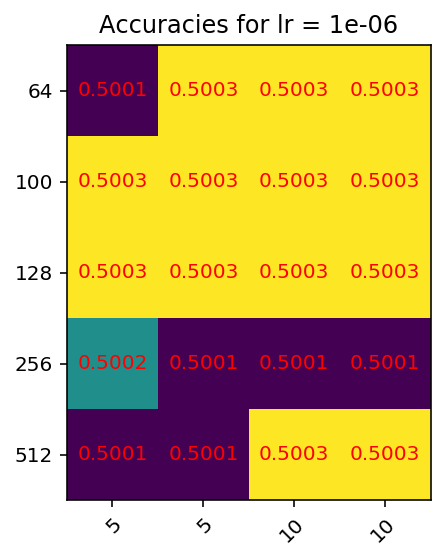

In [0]:
lr_index = 5
fig, ax = plt.subplots()
im = ax.imshow(accuracy_tuning[lr_index])

# We want to show all ticks...
ax.set_xticks(np.arange(len(epochs)))
ax.set_yticks(np.arange(len(batch_sizes)))
# ... and label them with the respective list entries
ax.set_xticklabels(epochs)
ax.set_yticklabels(batch_sizes)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(batch_sizes)):
    for j in range(len(epochs)):
        text = ax.text(j, i, np.around(accuracy_tuning[lr_index][i][j], decimals = 4),
                       ha="center", va="center", color="r")

ax.set_title(f"Accuracies for lr = {lrs[lr_index]}")
fig.tight_layout()
plt.show()

In [0]:
autoencoder, encoder = Autoencoder(dims, init=init)

NameError: ignored

In [0]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

NameError: ignored

In [0]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` which represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [0]:
time_means_start = time.time()
y_pred_train_list = []
y_pred_train_list_means = []
accuracy_list = []
accuracy_means_list = []
accuracy_ae_means_list=[]
accuracy_ae_list = []
tsne_list = []
accuracy_dec_list = []
label_list = []
# dbs = [100, 50, 30, 20, 10] + [i for i in range(9, -1, -1)]
sensitivities = [100, 20, 10] + [5/i for i in range(1, 6, 1)]
for sensitivity in sensitivities:
  if os.path.exists(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/sensitivity:.2f}.npy')):
    X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/sensitivity:.2f}.npy'))
    labels = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/sensitivity:.2f}.npy'))
    labels = torch.Tensor(labels)
    X =  torch.Tensor(X)
  else:
    a = create_data(sparsity = 1,std=1/sensitivity)
    X = a[0]
    labels = a[1]
    np.save(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/sensitivity:.2f}.npy'), X)
    np.save(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/sensitivity:.2f}.npy'), labels)
  X = normalize(X.numpy(), axis = 0)

  #===========================#
  autoencoder, encoder = Autoencoder(dims, init=init)
  autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
  autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
  autoencoder.save_weights(os.path.join(synthetic_path, f"ae_sparsity_1_std_{1/sensitivity:.2f}.h5"))
  encoding = encoder.predict(X)
  kmmeans = KMeans(n_clusters=2, n_init = 15).fit(encoding)
  y_pred_ae_means = kmmeans.labels_
  accs_ae_means = metrics.acc(labels.numpy().reshape(10002,), y_pred_ae_means.reshape(10002,))
  print("Accuracy",sensitivity, accs_ae_means)
  accuracy_ae_means_list.append(accs_ae_means)
  np.save(os.path.join(synthetic_path, f'encoding_sparsity_1_std_{1/sensitivity:.2f}.npy'), encoding)
  del kmmeans, accs_ae_means
  #============#
  clustering_layer = ClusteringLayer(n_clusters = 2, name='clustering')(encoder.output)
  model = Model(inputs=encoder.input, outputs=clustering_layer)
  model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
  k_means = KMeans(n_clusters=2, n_init=20)
  y_pred_ae = k_means.fit_predict(encoding) 
  y_pred_last = np.copy(y_pred_ae)
  model.get_layer(name='clustering').set_weights([k_means.cluster_centers_])
  # ===================#
  loss = 0
  index = 0
  maxiter = 8000
  update_interval = 140
  index_array = np.arange(X.shape[0])
  tol = 0.001 
  acc = 0
  #=====================#
  for ite in range(int(maxiter)):
      if ite % update_interval == 0:
          q = model.predict(X, verbose=0)
          p = target_distribution(q) 
          y_pred_ae = q.argmax(1)
          print(y_pred_ae.shape)
          print(labels.numpy().shape)
          if labels.numpy() is not None:
              acc = np.round(metrics.acc(labels.numpy().reshape(10002,), y_pred_ae), 5)
              nmi = np.round(metrics.nmi(labels.numpy().reshape(10002,), y_pred_ae), 5)
              ari = np.round(metrics.ari(labels.numpy().reshape(10002,), y_pred_ae), 5)
              loss = np.round(loss, 5)
              print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)
          delta_label = np.sum(y_pred_ae != y_pred_last).astype(np.float32) / y_pred_ae.shape[0]
          y_pred_last = np.copy(y_pred_ae)
          if ite > 0 and delta_label < tol:
              print('delta_label ', delta_label, '< tol ', tol)
              print('Reached tolerance threshold. Stopping training.')
              break
      idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
      loss = model.train_on_batch(x=X[idx], y=p[idx])
      index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0
  accuracy_dec_list.append(acc)
  model.save_weights(os.path.join(synthetic_path, f'DEC_model_final_sparsity_1_std_{1/sensitivity:.2f}.h5'))
  encoded_dec = encoder.predict(X)
  np.save(os.path.join(synthetic_path, f'encoded_dec_sparsity_1_std_{1/sensitivity:.2f}.npy'), encoded_dec)
  del encoding, loss, idx, index, model,acc,nmi, ari, clustering_layer, k_means, y_pred_last, delta_label, encoded_dec
  #===========================#

  #=========================#
  gmmodel = mixture.GaussianMixture(n_components = 2, random_state = 42)
  gmmodel.fit(X)  
  y_pred_train = gmmodel.predict(X)
  print(f'Gaussian Mixtures Models Done for std = {1/sensitivity:.2f}. Time elapsed = {time.time()-time_means_start:.2f}s')
  accuracy = metrics.acc(labels.numpy(), y_pred_train)
  print(f'Gaussian Mixture Model Accuracy = {(accuracy)*100:.2f}%')
  #===========================#

  #===========================#
  kmodel = KMeans(n_clusters = 2, random_state = 42)
  kmeans = kmodel.fit(X)
  print(f'KMeans completed. Time elapsed = {time.time()-time_means_start:.2f}s')
  y_pred_train_means = kmeans.labels_
  accuracy_means = metrics.acc(labels.numpy(), y_pred_train_means)
  print(f'KMeans Accuracy = {accuracy_means*100:.2f}%')
  #===========================#
  
  #===========================#
  # print(f'TSNE Started. Time elapsed = {time.time()-time_means_start:.2f}s')
  # tsne =  TSNE(n_components=2, random_state=42).fit_transform(X)
  # np.save(os.path.join(synthetic_path, f'tsne_sparsity_1_sensitivity_{sensitivity}'), tsne)
  # print(f'TSNE Completed. Time elapsed = {time.time()-time_means_start:.2f}s')
  # tsne_list.append(tsne)
  # del tsne
  #===========================#

  #===========================#
  y_pred_train_list_means.append(y_pred_train_means)
  accuracy_means_list.append(accuracy_means)
  accuracy_list.append(accuracy)
  y_pred_train_list.append(y_pred_train)
  label_list.append(labels)
  
  np.save(os.path.join(synthetic_path, f'gmm_preds_sparsity_1_std_{1/sensitivity:.2f}'), y_pred_train)
  np.save(os.path.join(synthetic_path, f'kmeans_preds_sparsity_1_std_{1/sensitivity:.2f}'), y_pred_train_means)
  del kmodel
  del autoencoder
  del encoder
  del gmmodel
  del X
  del labels
  del y_pred_train
  print(f'Done time elapsed = {time.time()-time_means_start:.2f}s') 

Epoch 1/30
10002/10002 [==============================] - 2s 191us/step - loss: 0.0883
Epoch 2/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0013
Epoch 3/30
10002/10002 [==============================] - 1s 56us/step - loss: 0.0021
Epoch 4/30
10002/10002 [==============================] - 1s 56us/step - loss: 2.8726e-04
Epoch 5/30
10002/10002 [==============================] - 1s 56us/step - loss: 1.2786e-04
Epoch 6/30
10002/10002 [==============================] - 1s 57us/step - loss: 1.3770e-04
Epoch 7/30
10002/10002 [==============================] - 1s 57us/step - loss: 1.0394e-04
Epoch 8/30
10002/10002 [==============================] - 1s 59us/step - loss: 8.7034e-05
Epoch 9/30
10002/10002 [==============================] - 1s 57us/step - loss: 7.5205e-05
Epoch 10/30
10002/10002 [==============================] - 1s 57us/step - loss: 4.2812e-05
Epoch 11/30
10002/10002 [==============================] - 1s 57us/step - loss: 6.6054e-05
Epoch 12/30
10002/1

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


(10002,)
(10002, 1)
Iter 0: acc = 1.00000, nmi = 1.00000, ari = 1.00000  ; loss= 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 1.00000, nmi = 1.00000, ari = 1.00000  ; loss= 0.00096
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.01. Time elapsed = 26.94s
Gaussian Mixture Model Accuracy = 100.00%
KMeans completed. Time elapsed = 27.12s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 100.00%
Done time elapsed = 27.20s
Creating Uniform data
Creating Sparse Data
Epoch 1/30
10002/10002 [==============================] - 2s 227us/step - loss: 0.0896
Epoch 2/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0014
Epoch 3/30
10002/10002 [==============================] - 1s 57us/step - loss: 8.5859e-04
Epoch 4/30
10002/10002 [==============================] - 1s 56us/step - loss: 2.8772e-04
Epoch 5/30
10002/10002 [==============================] - 1s 58us/step - loss: 1.6076e-04
Epoch 6/30
10002/10002 [==============================] - 1s 58us/step - loss: 7.9731e-05
Epoch 7/30
10002/10002 [==============================] - 1s 54us/step - loss: 8.5103e-05
Epoch 8/30
10002/10002 [==============================] - 1s 59us/step - loss: 7.2647e-05
Epoch 9/30
10002/10002 [==============================] - 1s 57us/step - loss: 7.1080e-05
Epoch 10/30
10002/10002 [==============================] - 1s 58us/step - loss: 7.8064e-05
Epoch 11/3

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 20 1.0
(10002,)
(10002, 1)
Iter 0: acc = 1.00000, nmi = 1.00000, ari = 1.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 1.00000, nmi = 1.00000, ari = 1.00000  ; loss= 0.0068
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.05. Time elapsed = 56.01s
Gaussian Mixture Model Accuracy = 100.00%
KMeans completed. Time elapsed = 56.19s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 100.00%
Done time elapsed = 56.27s
Epoch 1/30
10002/10002 [==============================] - 3s 278us/step - loss: 0.0915
Epoch 2/30
10002/10002 [==============================] - 1s 59us/step - loss: 0.0021
Epoch 3/30
10002/10002 [==============================] - 1s 58us/step - loss: 5.0540e-04
Epoch 4/30
10002/10002 [==============================] - 1s 64us/step - loss: 2.2445e-04
Epoch 5/30
10002/10002 [==============================] - 1s 57us/step - loss: 1.5698e-04
Epoch 6/30
10002/10002 [==============================] - 1s 59us/step - loss: 7.1459e-05
Epoch 7/30
10002/10002 [==============================] - 1s 59us/step - loss: 7.8547e-05
Epoch 8/30
10002/10002 [==============================] - 1s 58us/step - loss: 5.0269e-05
Epoch 9/30
10002/10002 [==============================] - 1s 59us/step - loss: 7.0820e-05
Epoch 10/30
10002/10002 [==============================] - 1s 56us/step - loss: 1.1894e-04
Epoch 11/30
10002/10002 [============================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 10 1.0
(10002,)
(10002, 1)
Iter 0: acc = 1.00000, nmi = 1.00000, ari = 1.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 1.00000, nmi = 1.00000, ari = 1.00000  ; loss= 0.00159
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.10. Time elapsed = 88.17s
Gaussian Mixture Model Accuracy = 100.00%
KMeans completed. Time elapsed = 88.37s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 100.00%
Done time elapsed = 88.45s
Epoch 1/30
10002/10002 [==============================] - 3s 308us/step - loss: 0.0926
Epoch 2/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0014
Epoch 3/30
10002/10002 [==============================] - 1s 59us/step - loss: 5.1279e-04
Epoch 4/30
10002/10002 [==============================] - 1s 57us/step - loss: 3.2276e-04
Epoch 5/30
10002/10002 [==============================] - 1s 58us/step - loss: 8.4797e-04
Epoch 6/30
10002/10002 [==============================] - 1s 57us/step - loss: 3.9076e-04
Epoch 7/30
10002/10002 [==============================] - 1s 59us/step - loss: 1.5592e-04
Epoch 8/30
10002/10002 [==============================] - 1s 58us/step - loss: 1.0870e-04
Epoch 9/30
10002/10002 [==============================] - 1s 58us/step - loss: 1.6877e-04
Epoch 10/30
10002/10002 [==============================] - 1s 59us/step - loss: 9.2521e-05
Epoch 11/30
10002/10002 [============================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 5.0 1.0
(10002,)
(10002, 1)
Iter 0: acc = 1.00000, nmi = 1.00000, ari = 1.00000  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 1.00000, nmi = 1.00000, ari = 1.00000  ; loss= 0.00557
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.20. Time elapsed = 123.32s
Gaussian Mixture Model Accuracy = 100.00%
KMeans completed. Time elapsed = 123.50s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans Accuracy = 100.00%
Done time elapsed = 123.58s
Creating Uniform data
Creating Sparse Data
Epoch 1/30
10002/10002 [==============================] - 4s 357us/step - loss: 0.0977
Epoch 2/30
10002/10002 [==============================] - 1s 59us/step - loss: 0.0015
Epoch 3/30
10002/10002 [==============================] - 1s 57us/step - loss: 5.4250e-04
Epoch 4/30
10002/10002 [==============================] - 1s 61us/step - loss: 4.8587e-04
Epoch 5/30
10002/10002 [==============================] - 1s 60us/step - loss: 3.5126e-04
Epoch 6/30
10002/10002 [==============================] - 1s 58us/step - loss: 4.3768e-04
Epoch 7/30
10002/10002 [==============================] - 1s 56us/step - loss: 2.8838e-04
Epoch 8/30
10002/10002 [==============================] - 1s 59us/step - loss: 2.6566e-04
Epoch 9/30
10002/10002 [==============================] - 1s 61us/step - loss: 2.4943e-04
Epoch 10/30
10002/10002 [==============================] - 1s 60us/step - loss: 2.1298e-04
Epoch 11/

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 2.5 0.8396320735852829
(10002,)
(10002, 1)
Iter 0: acc = 0.84003, nmi = 0.40783, ari = 0.46244  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.84193, nmi = 0.42293, ari = 0.46762  ; loss= 0.00935


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.84993, nmi = 0.45454, ari = 0.48976  ; loss= 0.06333


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.85103, nmi = 0.47393, ari = 0.49284  ; loss= 0.0121


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.85233, nmi = 0.48784, ari = 0.49650  ; loss= 0.08203


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.84963, nmi = 0.48839, ari = 0.48892  ; loss= 0.01136


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.85033, nmi = 0.49376, ari = 0.49088  ; loss= 0.0852


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.84963, nmi = 0.49398, ari = 0.48892  ; loss= 0.01021


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.85153, nmi = 0.49879, ari = 0.49425  ; loss= 0.07872


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.85173, nmi = 0.50031, ari = 0.49481  ; loss= 0.00915


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.85193, nmi = 0.50127, ari = 0.49537  ; loss= 0.06874
delta_label  0.0003999200159968006 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.40. Time elapsed = 174.13s
Gaussian Mixture Model Accuracy = 99.62%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans completed. Time elapsed = 174.35s
KMeans Accuracy = 99.18%
Done time elapsed = 174.44s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Epoch 1/30
10002/10002 [==============================] - 4s 402us/step - loss: 0.0757
Epoch 2/30
10002/10002 [==============================] - 1s 60us/step - loss: 0.0012
Epoch 3/30
10002/10002 [==============================] - 1s 60us/step - loss: 6.1391e-04
Epoch 4/30
10002/10002 [==============================] - 1s 58us/step - loss: 3.6173e-04
Epoch 5/30
10002/10002 [==============================] - 1s 59us/step - loss: 2.8917e-04
Epoch 6/30
10002/10002 [==============================] - 1s 58us/step - loss: 5.4869e-04
Epoch 7/30
10002/10002 [==============================] - 1s 60us/step - loss: 1.9264e-04
Epoch 8/30
10002/10002 [==============================] - 1s 59us/step - loss: 3.2402e-04
Epoch 9/30
10002/10002 [==============================] - 1s 57us/step - loss: 2.1030e-04
Epoch 10/30
10002/10002 [==============================] - 1s 60us/step - loss: 2.3858e-04
Epoch 11/30
10002/10002 [==============================] - 1s 60us/step - loss: 1.3908e-04
Epoch 12/30
100

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 1.6666666666666667 0.7792441511697661
(10002,)
(10002, 1)
Iter 0: acc = 0.77924, nmi = 0.24141, ari = 0.31184  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.77554, nmi = 0.24100, ari = 0.30363  ; loss= 0.01416


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.77455, nmi = 0.24118, ari = 0.30143  ; loss= 0.01692


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.77554, nmi = 0.24385, ari = 0.30363  ; loss= 0.02232


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.77514, nmi = 0.24569, ari = 0.30275  ; loss= 0.013


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.77904, nmi = 0.25056, ari = 0.31140  ; loss= 0.02988


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.77754, nmi = 0.25023, ari = 0.30806  ; loss= 0.01175


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.78404, nmi = 0.25735, ari = 0.32266  ; loss= 0.03131


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.78534, nmi = 0.25976, ari = 0.32562  ; loss= 0.01707


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.78744, nmi = 0.26251, ari = 0.33043  ; loss= 0.02641


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.78754, nmi = 0.26317, ari = 0.33066  ; loss= 0.0255


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.79074, nmi = 0.26794, ari = 0.33806  ; loss= 0.02535


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.79074, nmi = 0.26672, ari = 0.33806  ; loss= 0.02688


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.79164, nmi = 0.26766, ari = 0.34015  ; loss= 0.02379


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.79164, nmi = 0.26670, ari = 0.34015  ; loss= 0.02702


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.79264, nmi = 0.26744, ari = 0.34249  ; loss= 0.02318


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.79364, nmi = 0.26825, ari = 0.34484  ; loss= 0.03127


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.79474, nmi = 0.27027, ari = 0.34742  ; loss= 0.02098


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.79654, nmi = 0.27263, ari = 0.35168  ; loss= 0.03358


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.79684, nmi = 0.27326, ari = 0.35239  ; loss= 0.01765


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.79724, nmi = 0.27336, ari = 0.35334  ; loss= 0.03237


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.79784, nmi = 0.27467, ari = 0.35477  ; loss= 0.01659


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.79854, nmi = 0.27563, ari = 0.35644  ; loss= 0.02999


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.79894, nmi = 0.27648, ari = 0.35740  ; loss= 0.01673


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.79964, nmi = 0.27754, ari = 0.35907  ; loss= 0.02748


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.80024, nmi = 0.27893, ari = 0.36051  ; loss= 0.01708


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.80054, nmi = 0.27918, ari = 0.36123  ; loss= 0.02571


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.80224, nmi = 0.28274, ari = 0.36533  ; loss= 0.01769


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.80264, nmi = 0.28338, ari = 0.36630  ; loss= 0.0237


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.80334, nmi = 0.28493, ari = 0.36800  ; loss= 0.01743


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.80414, nmi = 0.28644, ari = 0.36994  ; loss= 0.02237


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.80454, nmi = 0.28724, ari = 0.37091  ; loss= 0.01772


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.80504, nmi = 0.28840, ari = 0.37213  ; loss= 0.02067


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.80494, nmi = 0.28810, ari = 0.37189  ; loss= 0.01917


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.80654, nmi = 0.29159, ari = 0.37580  ; loss= 0.01945


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.80634, nmi = 0.29103, ari = 0.37531  ; loss= 0.01916


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.80644, nmi = 0.29144, ari = 0.37556  ; loss= 0.01833


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.80694, nmi = 0.29241, ari = 0.37678  ; loss= 0.01975


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.80684, nmi = 0.29242, ari = 0.37654  ; loss= 0.01724


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.80664, nmi = 0.29204, ari = 0.37605  ; loss= 0.02099
delta_label  0.0007998400319936012 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.60. Time elapsed = 270.38s
Gaussian Mixture Model Accuracy = 80.38%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans completed. Time elapsed = 270.76s
KMeans Accuracy = 79.63%
Done time elapsed = 270.83s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Epoch 1/30
10002/10002 [==============================] - 4s 445us/step - loss: 0.0767
Epoch 2/30
10002/10002 [==============================] - 1s 61us/step - loss: 0.0013
Epoch 3/30
10002/10002 [==============================] - 1s 57us/step - loss: 6.2647e-04
Epoch 4/30
10002/10002 [==============================] - 1s 62us/step - loss: 6.5491e-04
Epoch 5/30
10002/10002 [==============================] - 1s 60us/step - loss: 7.6163e-04
Epoch 6/30
10002/10002 [==============================] - 1s 64us/step - loss: 4.5475e-04
Epoch 7/30
10002/10002 [==============================] - 1s 62us/step - loss: 3.1851e-04
Epoch 8/30
10002/10002 [==============================] - 1s 59us/step - loss: 2.6458e-04
Epoch 9/30
10002/10002 [==============================] - 1s 59us/step - loss: 2.2862e-04
Epoch 10/30
10002/10002 [==============================] - 1s 58us/step - loss: 2.3079e-04
Epoch 11/30
10002/10002 [==============================] - 1s 60us/step - loss: 2.2121e-04
Epoch 12/30
100

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 1.25 0.6690661867626475
(10002,)
(10002, 1)
Iter 0: acc = 0.66907, nmi = 0.11805, ari = 0.11426  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.68476, nmi = 0.12254, ari = 0.13647  ; loss= 0.02987


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.69526, nmi = 0.12710, ari = 0.15243  ; loss= 0.05783


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.69576, nmi = 0.12785, ari = 0.15321  ; loss= 0.02958


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.70306, nmi = 0.13379, ari = 0.16485  ; loss= 0.09083


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.69646, nmi = 0.12804, ari = 0.15431  ; loss= 0.02519


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.69976, nmi = 0.13027, ari = 0.15954  ; loss= 0.10029


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.69046, nmi = 0.12130, ari = 0.14502  ; loss= 0.03024


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.68866, nmi = 0.11789, ari = 0.14229  ; loss= 0.07298


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.69296, nmi = 0.11968, ari = 0.14886  ; loss= 0.04123


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.69586, nmi = 0.11999, ari = 0.15336  ; loss= 0.13587


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.69036, nmi = 0.11477, ari = 0.14487  ; loss= 0.0578


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.68816, nmi = 0.11140, ari = 0.14154  ; loss= 0.08752


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.67576, nmi = 0.09811, ari = 0.12349  ; loss= 0.07072


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.66967, nmi = 0.08903, ari = 0.11506  ; loss= 0.04834


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.65087, nmi = 0.07133, ari = 0.09096  ; loss= 0.10918


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.64367, nmi = 0.06303, ari = 0.08248  ; loss= 0.0219


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.62537, nmi = 0.04830, ari = 0.06279  ; loss= 0.11904


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.61808, nmi = 0.04273, ari = 0.05568  ; loss= 0.04348


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.59578, nmi = 0.02779, ari = 0.03660  ; loss= 0.09429


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.58528, nmi = 0.02211, ari = 0.02900  ; loss= 0.0657


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.55969, nmi = 0.01058, ari = 0.01415  ; loss= 0.11033


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.54669, nmi = 0.00648, ari = 0.00862  ; loss= 0.12969


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.52949, nmi = 0.00256, ari = 0.00338  ; loss= 0.12691


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.52040, nmi = 0.00122, ari = 0.00157  ; loss= 0.04649


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.50280, nmi = 0.00002, ari = -0.00007  ; loss= 0.10235


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.51010, nmi = 0.00029, ari = 0.00031  ; loss= 0.14027


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.52809, nmi = 0.00228, ari = 0.00306  ; loss= 0.11557


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.53039, nmi = 0.00267, ari = 0.00360  ; loss= 0.32603


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.54569, nmi = 0.00606, ari = 0.00825  ; loss= 0.11104


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.53879, nmi = 0.00437, ari = 0.00592  ; loss= 0.30988


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.55169, nmi = 0.00777, ari = 0.01059  ; loss= 0.10241


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.54329, nmi = 0.00544, ari = 0.00740  ; loss= 0.30002


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.55789, nmi = 0.00975, ari = 0.01331  ; loss= 0.09855


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.55099, nmi = 0.00755, ari = 0.01030  ; loss= 0.30904


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.56459, nmi = 0.01218, ari = 0.01659  ; loss= 0.099


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.55799, nmi = 0.00981, ari = 0.01335  ; loss= 0.3206


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.56869, nmi = 0.01382, ari = 0.01877  ; loss= 0.09522


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.56009, nmi = 0.01058, ari = 0.01434  ; loss= 0.31228


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.57309, nmi = 0.01574, ari = 0.02127  ; loss= 0.09013


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.56649, nmi = 0.01305, ari = 0.01759  ; loss= 0.29733


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.57419, nmi = 0.01629, ari = 0.02192  ; loss= 0.08486


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.56879, nmi = 0.01404, ari = 0.01883  ; loss= 0.28336


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.57768, nmi = 0.01795, ari = 0.02404  ; loss= 0.08597


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.57019, nmi = 0.01470, ari = 0.01961  ; loss= 0.27318


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.58178, nmi = 0.02013, ari = 0.02666  ; loss= 0.0911


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.57349, nmi = 0.01630, ari = 0.02151  ; loss= 0.26148


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.58458, nmi = 0.02171, ari = 0.02852  ; loss= 0.10428


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.57648, nmi = 0.01784, ari = 0.02331  ; loss= 0.25135


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.58708, nmi = 0.02327, ari = 0.03024  ; loss= 0.109


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.58308, nmi = 0.02127, ari = 0.02752  ; loss= 0.24412


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.59128, nmi = 0.02567, ari = 0.03324  ; loss= 0.108


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.58738, nmi = 0.02361, ari = 0.03045  ; loss= 0.2427


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.59588, nmi = 0.02847, ari = 0.03668  ; loss= 0.09638


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.59288, nmi = 0.02673, ari = 0.03442  ; loss= 0.24072


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.60108, nmi = 0.03177, ari = 0.04078  ; loss= 0.09009


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.59878, nmi = 0.03031, ari = 0.03894  ; loss= 0.23921


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.60928, nmi = 0.03729, ari = 0.04768  ; loss= 0.0771


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 0.80. Time elapsed = 397.08s
Gaussian Mixture Model Accuracy = 63.34%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans completed. Time elapsed = 397.44s
KMeans Accuracy = 63.36%
Done time elapsed = 397.51s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Epoch 1/30
10002/10002 [==============================] - 5s 500us/step - loss: 0.0718
Epoch 2/30
10002/10002 [==============================] - 1s 59us/step - loss: 0.0012
Epoch 3/30
10002/10002 [==============================] - 1s 60us/step - loss: 3.7133e-04
Epoch 4/30
10002/10002 [==============================] - 1s 58us/step - loss: 3.4280e-04
Epoch 5/30
10002/10002 [==============================] - 1s 61us/step - loss: 3.3857e-04
Epoch 6/30
10002/10002 [==============================] - 1s 62us/step - loss: 3.3023e-04
Epoch 7/30
10002/10002 [==============================] - 1s 59us/step - loss: 2.0374e-04
Epoch 8/30
10002/10002 [==============================] - 1s 59us/step - loss: 2.2958e-04
Epoch 9/30
10002/10002 [==============================] - 1s 59us/step - loss: 2.6349e-04
Epoch 10/30
10002/10002 [==============================] - 1s 62us/step - loss: 2.5680e-04
Epoch 11/30
10002/10002 [==============================] - 1s 61us/step - loss: 1.9259e-04
Epoch 12/30
100

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 1.0 0.5615876824635073
(10002,)
(10002, 1)
Iter 0: acc = 0.56219, nmi = 0.01191, ari = 0.01538  ; loss= 0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.56359, nmi = 0.01216, ari = 0.01608  ; loss= 0.01146


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.56689, nmi = 0.01307, ari = 0.01780  ; loss= 0.09239


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 420: acc = 0.56889, nmi = 0.01375, ari = 0.01888  ; loss= 0.02201


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 560: acc = 0.57039, nmi = 0.01441, ari = 0.01972  ; loss= 0.18207


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 700: acc = 0.57219, nmi = 0.01526, ari = 0.02075  ; loss= 0.02903


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 840: acc = 0.57259, nmi = 0.01538, ari = 0.02098  ; loss= 0.16784


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 980: acc = 0.57269, nmi = 0.01538, ari = 0.02104  ; loss= 0.02314


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1120: acc = 0.57369, nmi = 0.01575, ari = 0.02162  ; loss= 0.1331


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1260: acc = 0.57499, nmi = 0.01629, ari = 0.02239  ; loss= 0.01695


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1400: acc = 0.57508, nmi = 0.01634, ari = 0.02245  ; loss= 0.14688


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1540: acc = 0.57528, nmi = 0.01645, ari = 0.02257  ; loss= 0.01686


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1680: acc = 0.57469, nmi = 0.01625, ari = 0.02221  ; loss= 0.10922


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1820: acc = 0.57528, nmi = 0.01655, ari = 0.02257  ; loss= 0.01673


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 1960: acc = 0.57499, nmi = 0.01647, ari = 0.02239  ; loss= 0.13822


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2100: acc = 0.57329, nmi = 0.01577, ari = 0.02139  ; loss= 0.01433


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2240: acc = 0.57419, nmi = 0.01626, ari = 0.02192  ; loss= 0.0892


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2380: acc = 0.57299, nmi = 0.01586, ari = 0.02121  ; loss= 0.01358


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2520: acc = 0.57079, nmi = 0.01518, ari = 0.01995  ; loss= 0.04089


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2660: acc = 0.57039, nmi = 0.01507, ari = 0.01972  ; loss= 0.01532


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2800: acc = 0.56749, nmi = 0.01426, ari = 0.01813  ; loss= 0.0193


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 2940: acc = 0.56679, nmi = 0.01399, ari = 0.01775  ; loss= 0.01535


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3080: acc = 0.56559, nmi = 0.01385, ari = 0.01712  ; loss= 0.00815


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3220: acc = 0.56549, nmi = 0.01382, ari = 0.01706  ; loss= 0.01428


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3360: acc = 0.56529, nmi = 0.01404, ari = 0.01696  ; loss= 0.00705


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3500: acc = 0.56409, nmi = 0.01350, ari = 0.01634  ; loss= 0.01348


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3640: acc = 0.56489, nmi = 0.01411, ari = 0.01675  ; loss= 0.00617


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3780: acc = 0.56359, nmi = 0.01357, ari = 0.01609  ; loss= 0.01301


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 3920: acc = 0.56439, nmi = 0.01352, ari = 0.01649  ; loss= 0.00541


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4060: acc = 0.56449, nmi = 0.01323, ari = 0.01654  ; loss= 0.01117


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4200: acc = 0.56419, nmi = 0.01330, ari = 0.01639  ; loss= 0.01041


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4340: acc = 0.56289, nmi = 0.01281, ari = 0.01573  ; loss= 0.01273


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4480: acc = 0.56309, nmi = 0.01322, ari = 0.01583  ; loss= 0.00478


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4620: acc = 0.56219, nmi = 0.01289, ari = 0.01538  ; loss= 0.01317


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4760: acc = 0.56189, nmi = 0.01300, ari = 0.01523  ; loss= 0.00333


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 4900: acc = 0.56189, nmi = 0.01307, ari = 0.01523  ; loss= 0.01221


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5040: acc = 0.56089, nmi = 0.01281, ari = 0.01474  ; loss= 0.00492


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5180: acc = 0.56019, nmi = 0.01256, ari = 0.01440  ; loss= 0.01176


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5320: acc = 0.55949, nmi = 0.01234, ari = 0.01407  ; loss= 0.00616


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5460: acc = 0.56009, nmi = 0.01258, ari = 0.01436  ; loss= 0.01119


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5600: acc = 0.55919, nmi = 0.01232, ari = 0.01393  ; loss= 0.00625


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5740: acc = 0.56049, nmi = 0.01287, ari = 0.01455  ; loss= 0.01031


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 5880: acc = 0.55999, nmi = 0.01276, ari = 0.01431  ; loss= 0.00547


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6020: acc = 0.55929, nmi = 0.01259, ari = 0.01398  ; loss= 0.01042


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6160: acc = 0.55639, nmi = 0.01165, ari = 0.01264  ; loss= 0.00726


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6300: acc = 0.55669, nmi = 0.01176, ari = 0.01277  ; loss= 0.01081


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6440: acc = 0.55699, nmi = 0.01198, ari = 0.01291  ; loss= 0.00572


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6580: acc = 0.55659, nmi = 0.01178, ari = 0.01273  ; loss= 0.01168


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6720: acc = 0.55559, nmi = 0.01153, ari = 0.01228  ; loss= 0.0047


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 6860: acc = 0.55559, nmi = 0.01150, ari = 0.01228  ; loss= 0.0115


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7000: acc = 0.55479, nmi = 0.01132, ari = 0.01193  ; loss= 0.00457


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7140: acc = 0.55569, nmi = 0.01168, ari = 0.01232  ; loss= 0.01058


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7280: acc = 0.55329, nmi = 0.01084, ari = 0.01128  ; loss= 0.00433


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7420: acc = 0.55479, nmi = 0.01141, ari = 0.01193  ; loss= 0.01105


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7560: acc = 0.55299, nmi = 0.01079, ari = 0.01115  ; loss= 0.00386


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7700: acc = 0.55489, nmi = 0.01146, ari = 0.01197  ; loss= 0.01113


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7840: acc = 0.55299, nmi = 0.01082, ari = 0.01115  ; loss= 0.00369


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 7980: acc = 0.55339, nmi = 0.01101, ari = 0.01132  ; loss= 0.01062


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Gaussian Mixtures Models Done for std = 1.00. Time elapsed = 530.93s
Gaussian Mixture Model Accuracy = 54.79%


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


KMeans completed. Time elapsed = 531.36s
KMeans Accuracy = 55.92%
Done time elapsed = 531.43s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


### Visualization and Evaluation

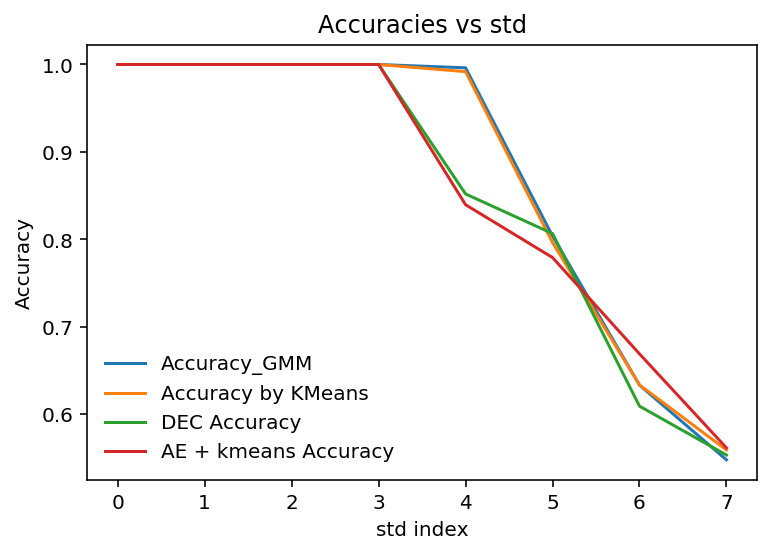

In [0]:
tol = 0.001
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(accuracy_list, label='Accuracy_GMM')
plt.plot(accuracy_means_list, label = 'Accuracy by KMeans')
plt.xlabel('std index')
plt.ylabel("Accuracy")
plt.plot(accuracy_dec_list, label='DEC Accuracy')
plt.plot(accuracy_ae_means_list, label = 'AE + kmeans Accuracy')
# plt.plot(accuracy_ae_list, label = 'AE Accuracy')
plt.legend(frameon=False)
plt.title('Accuracies vs std')
plt.savefig(os.path.join(synthetic_path,f'Accuracies_vs_stds_tol_{tol}_update_interval_{update_interval}.png'))

In [0]:
j = 10
X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_sensitivity_{j}.npy'))
y = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_sensitivity_{j}.npy'))
np.max(X)

702.94885

In [0]:
time_start = time.time()
js = [100, 10, 5, 5/3, 5/4,1]
for j in js:
  a = create_data(sparsity = 1, std= 1/j)
  X = a[0].numpy()
  y = a[1].numpy()
  np.save(os.path.join(synthetic_path, f'X_sparsity_1_std_{1/j:.2f}.npy'),X)
  np.save(os.path.join(synthetic_path, f'labels_sparsity_1_std_{1/j:.2f}.npy'), y)
  
  tsne = TSNE(n_components=2).fit_transform(X)
  print(f'TSNE done. Time elapsed = {time.time()- time_start:.2f}s')

  for i in tqdm(range(len(tsne))):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(y[i].item())])
  plt.title(f'TSNE Vis. W/O Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'tsne_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  print(f'Visualized TSNE Grounds. Time elapsed = {time.time()- time_start:.2f}s')
  del tsne

  pca = PCA(n_components=2).fit_transform(X)
  print(f'PCA done. Time elapsed = {time.time()- time_start:.2f}s')

  for i in tqdm(range(len(pca))):
    plt.scatter(pca[i][0], pca[i][1], c=colors[int(y[i].item())])
  plt.title(f'PCA Vis. W/O Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'pca_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))  
  plt.clf()
  print(f'Visualized PCA Grounds. Time elapsed = {time.time()- time_start:.2f}s')  
  del pca

  Lda = LinearDiscriminantAnalysis(n_components=2)
  lda = Lda.fit_transform(X, y.reshape(len(y),))
  plt.hist(lda)
  plt.title(f'LDA Vis. W/O Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'lda_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  del lda, Lda
  print(f'LDA done. Time elapsed = {time.time()- time_start:.2f}s')

  if(j == 100):
      to_conc = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
      po_conc = cv2.imread(os.path.join(synthetic_path, f'pca_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
      lo_conc = cv2.imread(os.path.join(synthetic_path, f'lda_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
  else:
    ton = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
    po = cv2.imread(os.path.join(synthetic_path,f'pca_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
    lo = cv2.imread(os.path.join(synthetic_path, f'lda_visualization_wo_normalization_ground_truth_std_{1/j:.2f}.png'))
    to_conc = cv2.hconcat([to_conc, ton])
    po_conc = cv2.hconcat([po_conc, po])
    lo_conc = cv2.hconcat([lo_conc, lo])
    del ton,po,lo  

  X = normalize(X, axis = 0)
  print('Normalized.')

  tsne = TSNE(n_components=2).fit_transform(X)
  print(f'TSNE done. Time elapsed = {time.time()- time_start:.2f}s')

  for i in tqdm(range(len(tsne))):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(y[i].item())])
  plt.title(f'TSNE Vis. W/ Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'tsne_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  print(f'Visualized TSNE Grounds. Time elapsed = {time.time()- time_start:.2f}s')
  del tsne

  pca = PCA(n_components=2).fit_transform(X)
  print(f'PCA done. Time elapsed = {time.time()- time_start:.2f}s')

  for i in tqdm(range(len(pca))):
    plt.scatter(pca[i][0], pca[i][1], c=colors[int(y[i].item())])
  plt.title(f'PCA Vis. W/ Norm. on Ground Truth std {1/j:.2f}')
  plt.savefig(os.path.join(synthetic_path, f'pca_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  print(f'Visualized PCA Grounds. Time elapsed = {time.time()- time_start:.2f}s')
  
  del pca

  Lda = LinearDiscriminantAnalysis(n_components=2)
  lda = Lda.fit_transform(X, y.reshape(len(y),))
  plt.hist(lda)
  plt.title(f'LDA Vis. W/ Norm. on Ground Truth std {1/j:.2f}')
  plt.legend(frameon=False)
  plt.savefig(os.path.join(synthetic_path, f'lda_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
  plt.clf()
  del lda, Lda
  print(f'LDA done. Time elapsed = {time.time()- time_start:.2f}s')

  if(j == 100):
      t_conc = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
      p_conc = cv2.imread(os.path.join(synthetic_path, f'pca_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
      l_conc = cv2.imread(os.path.join(synthetic_path, f'lda_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
  else:
    t = cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
    p = cv2.imread(os.path.join(synthetic_path,f'pca_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
    l = cv2.imread(os.path.join(synthetic_path, f'lda_visualization_w_normalization_ground_truth_std_{1/j:.2f}.png'))
    t_conc = cv2.hconcat([t_conc, t])
    p_conc = cv2.hconcat([p_conc, p])
    l_conc = cv2.hconcat([l_conc, l])
    del t,p,l
  del X, y
  print(f'Done std {1/j:.2f}. Time Elapsed = {time.time()- time_start:.2f}s')

cv2.imwrite(os.path.join(synthetic_path, 'tsne_visualization_wo_normalization_for_all_std.png'), to_conc)
cv2.imwrite(os.path.join(synthetic_path, 'tsne_visualization_w_normalization_for_all_std.png'), t_conc)
cv2.imwrite(os.path.join(synthetic_path, 'pca_visualization_wo_normalization_for_all_std.png'), po_conc)
cv2.imwrite(os.path.join(synthetic_path, 'pca_visualization_w_normalization_for_all_std.png'), p_conc)
cv2.imwrite(os.path.join(synthetic_path, 'lda_visualization_wo_normalization_for_all_std.png'), lo_conc)
cv2.imwrite(os.path.join(synthetic_path, 'lda_visualization_w_normalization_for_all_std.png'), l_conc)

Creating Uniform data
Creating Sparse Data


  0%|          | 40/10002 [00:00<00:25, 393.34it/s]

TSNE done. Time elapsed = 77.62s


  0%|          | 38/10002 [00:00<00:26, 378.48it/s]

Visualized TSNE Grounds. Time elapsed = 142.27s
PCA done. Time elapsed = 142.29s


100%|██████████| 10002/10002 [01:00<00:00, 165.53it/s]


Visualized PCA Grounds. Time elapsed = 206.62s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 206.85s
Normalized.


  0%|          | 40/10002 [00:00<00:25, 392.09it/s]

TSNE done. Time elapsed = 288.23s


  0%|          | 37/10002 [00:00<00:27, 366.90it/s]

Visualized TSNE Grounds. Time elapsed = 352.03s
PCA done. Time elapsed = 352.06s


100%|██████████| 10002/10002 [01:00<00:00, 165.83it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 416.21s
LDA done. Time elapsed = 416.43s
Done std 0.01. Time Elapsed = 416.44s
Creating Uniform data
Creating Sparse Data


  0%|          | 38/10002 [00:00<00:26, 374.29it/s]

TSNE done. Time elapsed = 493.65s


  0%|          | 39/10002 [00:00<00:25, 387.95it/s]

Visualized TSNE Grounds. Time elapsed = 556.70s
PCA done. Time elapsed = 556.72s


100%|██████████| 10002/10002 [00:59<00:00, 167.34it/s]


Visualized PCA Grounds. Time elapsed = 620.35s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 620.57s
Normalized.


  0%|          | 39/10002 [00:00<00:26, 383.17it/s]

TSNE done. Time elapsed = 697.95s


  0%|          | 34/10002 [00:00<00:29, 337.86it/s]

Visualized TSNE Grounds. Time elapsed = 762.95s
PCA done. Time elapsed = 762.97s


100%|██████████| 10002/10002 [01:01<00:00, 162.33it/s]


Visualized PCA Grounds. Time elapsed = 828.47s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


LDA done. Time elapsed = 829.18s
Done std 0.10. Time Elapsed = 829.20s
Creating Uniform data
Creating Sparse Data


  0%|          | 38/10002 [00:00<00:26, 373.56it/s]

TSNE done. Time elapsed = 921.99s


  0%|          | 36/10002 [00:00<00:27, 357.54it/s]

Visualized TSNE Grounds. Time elapsed = 987.19s
PCA done. Time elapsed = 987.21s


100%|██████████| 10002/10002 [01:02<00:00, 159.76it/s]


Visualized PCA Grounds. Time elapsed = 1053.79s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 1054.02s
Normalized.


  0%|          | 36/10002 [00:00<00:27, 357.70it/s]

TSNE done. Time elapsed = 1133.59s


  0%|          | 34/10002 [00:00<00:29, 333.80it/s]

Visualized TSNE Grounds. Time elapsed = 1199.78s
PCA done. Time elapsed = 1199.80s


100%|██████████| 10002/10002 [01:03<00:00, 158.49it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 1266.93s
LDA done. Time elapsed = 1267.17s
Done std 0.20. Time Elapsed = 1267.18s
Creating Uniform data
Creating Sparse Data


  0%|          | 36/10002 [00:00<00:27, 359.77it/s]

TSNE done. Time elapsed = 1381.09s


  0%|          | 37/10002 [00:00<00:27, 364.61it/s]

Visualized TSNE Grounds. Time elapsed = 1447.54s
PCA done. Time elapsed = 1447.56s


100%|██████████| 10002/10002 [01:01<00:00, 161.41it/s]


Visualized PCA Grounds. Time elapsed = 1513.50s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 1513.73s
Normalized.


  0%|          | 34/10002 [00:00<00:29, 338.04it/s]

TSNE done. Time elapsed = 1628.35s


  0%|          | 34/10002 [00:00<00:29, 335.51it/s]

Visualized TSNE Grounds. Time elapsed = 1695.11s
PCA done. Time elapsed = 1695.14s


100%|██████████| 10002/10002 [01:03<00:00, 102.10it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 1762.43s
LDA done. Time elapsed = 1762.66s
Done std 0.60. Time Elapsed = 1762.67s
Creating Uniform data
Creating Sparse Data


  0%|          | 29/10002 [00:00<00:34, 285.16it/s]

TSNE done. Time elapsed = 1860.01s


  0%|          | 36/10002 [00:00<00:27, 359.68it/s]

Visualized TSNE Grounds. Time elapsed = 1925.56s
PCA done. Time elapsed = 1925.59s


100%|██████████| 10002/10002 [01:02<00:00, 158.83it/s]


Visualized PCA Grounds. Time elapsed = 1992.50s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 1992.72s
Normalized.


  0%|          | 31/10002 [00:00<00:32, 307.22it/s]

TSNE done. Time elapsed = 2079.83s


  0%|          | 35/10002 [00:00<00:28, 344.46it/s]

Visualized TSNE Grounds. Time elapsed = 2146.89s
PCA done. Time elapsed = 2146.91s


100%|██████████| 10002/10002 [01:02<00:00, 160.48it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 2213.20s
LDA done. Time elapsed = 2213.42s
Done std 0.80. Time Elapsed = 2213.43s
Creating Uniform data
Creating Sparse Data


  0%|          | 40/10002 [00:00<00:25, 386.27it/s]

TSNE done. Time elapsed = 2318.38s


  0%|          | 36/10002 [00:00<00:28, 351.88it/s]

Visualized TSNE Grounds. Time elapsed = 2383.50s
PCA done. Time elapsed = 2383.52s


100%|██████████| 10002/10002 [01:00<00:00, 164.21it/s]


Visualized PCA Grounds. Time elapsed = 2448.33s


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA done. Time elapsed = 2448.56s
Normalized.


  0%|          | 35/10002 [00:00<00:28, 346.23it/s]

TSNE done. Time elapsed = 2560.49s


  0%|          | 37/10002 [00:00<00:27, 363.66it/s]

Visualized TSNE Grounds. Time elapsed = 2625.95s
PCA done. Time elapsed = 2625.98s


100%|██████████| 10002/10002 [01:02<00:00, 160.74it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
No handles with labels found to put in legend.


Visualized PCA Grounds. Time elapsed = 2692.13s
LDA done. Time elapsed = 2692.36s
Done std 1.00. Time Elapsed = 2692.37s


True

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(39, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.4903896092592291


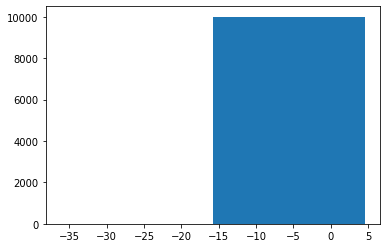

In [0]:
j = 10
X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_variance_{1/j:.2f}.npy'))
y = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_variance_{1/j:.2f}.npy'))
Lda = LinearDiscriminantAnalysis(n_components=2)
lda = Lda.fit_transform(X, y.reshape(len(y),), )
print(np.median(lda))
plt.hist(lda, bins = 2, range=(np.median(lda), ),  )
plt.savefig(os.path.join(synthetic_path, f'lda_visualization_wo_normalization_variance_{1/j:.2f}.png'))

In [0]:
j = 100
t= cv2.imread(os.path.join(synthetic_path, f'tsne_visualization_wo_normalization_ground_truth_variance_{1/j:.2f}.png'))
p= cv2.imread(os.path.join(synthetic_path,f'pca_visualization_wo_normalization_ground_truth_variance_{1/j:.2f}.png'))
h = cv2.hconcat([t,p])

In [0]:
cv2.imwrite(os.path.join(synthetic_path, f'visualization_wo_normalization_ground_truth_variance_{1/j:.2f}.png'), h)

True

In [0]:
time_enc = time.time() 
db = 9
# accuracy_ae = []
accuracy_ae_means_list = []
dbs = [100, 50, 30,20, 10] + [i for i in range(9, -1, -1)]
for db in dbs:
  encoding = np.load(os.path.join(synthetic_path, f'encoding_sparsity_1_db_{db}.npy'))
  y = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_db_{db}.npy'))

  kmeans = KMeans(n_clusters=2, n_init = 15).fit(encoding)
  y_pred_ae_means = kmeans.labels_
  accs_ae_means = metrics.acc(y.reshape(10002,), y_pred_ae_means.reshape(10002,))
  print("Accuracy",db, accs_ae_means)
  accuracy_ae_means_list.append(accs_ae_means)
  
  # y_pred_ae = np.argmax(encoding, axis = 1)
  # accs_ae = metrics.acc(y.reshape(10002,), y_pred_ae)
  # print("accuracy",db,accs_ae)
  # accuracy_ae.append(accs_ae)

  # for i in range(len(encoding)):
  #   plt.scatter(encoding[i][0], encoding[i][1], c = colors[int(y[i].item())])
  #   if(i% 250 ==0):
  #     print(".", end = "")
  #     plt.savefig(os.path.join(synthetic_path, f'Encoding_db_{db}.png'))
  # print(f"\n done time elapsed = {time.time()-time_enc:.2f}s")
  # plt.title(f'Encoding Visualization db {db}')
  # plt.savefig(os.path.join(synthetic_path, f'Encoding_db_{db}.png'))
  # plt.clf()
  del encoding, y, kmeans, y_pred_ae_means, accs_ae_means#, y_pred_ae, accs_ae

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 100 1.0
Accuracy 50 1.0
Accuracy 30 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 20 1.0
Accuracy 10 0.5002999400119976
Accuracy 9 0.5000999800039992


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 8 0.5008998200359928
Accuracy 7 0.5003999200159968
Accuracy 6 0.5005998800239952


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Accuracy 5 0.5001999600079984
Accuracy 4 0.5005998800239952
Accuracy 3 0.5000999800039992
Accuracy 2 0.5000999800039992
Accuracy 1 0.5005998800239952
Accuracy 0 0.5000999800039992


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


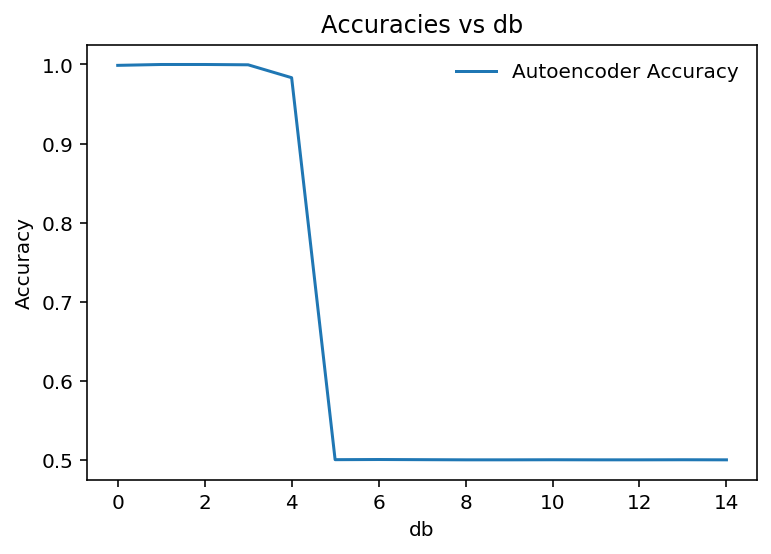

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.xlabel('db')
plt.ylabel("Accuracy")
plt.plot(accuracy_ae_means_list, label='Autoencoder Accuracy')
plt.legend(frameon=False)
plt.title('Accuracies vs db')
plt.savefig(os.path.join(synthetic_path,f'Accuracies_vs_dbs_autoencoder.png'))

In [0]:
time_start = time.time()
# tsne_model = TSNE(random_state = 42)
# print(f'TSNE started. Time collapsed = {(time.time()-time_start):.2f}s')
# tsne = tsne_model.fit_transform(X)
# print(f'TSNE completed. Time collapsed = {(time.time()-time_start):.2f}s')
# j = 2
for j in range(0, 18):
  tsne = np.load(os.path.join(synthetic_path, f'tsne_sparsity{j+1}.npy') )
  y_pred_train = np.load(os.path.join(synthetic_path, f'gmm_preds_sparsity{j}.npy'))
  for i in range(len(tsne)):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[y_pred_train[i]])
  del tsne
  del y_pred_train 
  print(f'done. Time collapsed ={time.time()-time_start}')
  plt.title(f'Visualization against the predicted clustering by GMM for Sparsity = {j+1}')
  plt.savefig(os.path.join(gmm_path,f'predictedGMM_for_Sparsity_{j+1}.png'))
  plt.clf()

done. Time collapsed =60.104713678359985
done. Time collapsed =122.83830094337463
done. Time collapsed =186.1231939792633
done. Time collapsed =252.53311562538147
done. Time collapsed =316.08072805404663
done. Time collapsed =380.33908104896545
done. Time collapsed =443.3959836959839
done. Time collapsed =506.5995943546295
done. Time collapsed =570.6039922237396
done. Time collapsed =634.7487516403198
done. Time collapsed =698.045307636261
done. Time collapsed =760.759204864502
done. Time collapsed =824.3234689235687
done. Time collapsed =887.3940515518188
done. Time collapsed =950.2635970115662
done. Time collapsed =1016.7553551197052
done. Time collapsed =1079.9479503631592
done. Time collapsed =1142.2407364845276


<Figure size 432x288 with 0 Axes>

In [0]:
a = torch.randn((5000,39))
X = torch.ones((1, 39))/39
m = X + 0.01*a 
m = torch.abs(m)
m = (m/torch.sum(m, dim = 1).view(-1,1))
m, c = torch.sort(m, dim = 1)

In [0]:
m[500:505]

tensor([[0.0012, 0.0100, 0.0125, 0.0132, 0.0133, 0.0156, 0.0164, 0.0171, 0.0174,
         0.0178, 0.0200, 0.0205, 0.0207, 0.0210, 0.0211, 0.0229, 0.0234, 0.0236,
         0.0240, 0.0241, 0.0259, 0.0265, 0.0265, 0.0274, 0.0288, 0.0290, 0.0308,
         0.0322, 0.0330, 0.0338, 0.0346, 0.0363, 0.0363, 0.0364, 0.0383, 0.0403,
         0.0410, 0.0419, 0.0452],
        [0.0026, 0.0090, 0.0101, 0.0118, 0.0139, 0.0156, 0.0159, 0.0159, 0.0163,
         0.0176, 0.0190, 0.0196, 0.0214, 0.0217, 0.0219, 0.0228, 0.0246, 0.0254,
         0.0260, 0.0268, 0.0274, 0.0276, 0.0279, 0.0291, 0.0294, 0.0296, 0.0311,
         0.0316, 0.0316, 0.0318, 0.0322, 0.0330, 0.0339, 0.0341, 0.0358, 0.0371,
         0.0450, 0.0454, 0.0486],
        [0.0063, 0.0077, 0.0081, 0.0098, 0.0117, 0.0120, 0.0132, 0.0136, 0.0137,
         0.0143, 0.0161, 0.0184, 0.0189, 0.0190, 0.0224, 0.0241, 0.0250, 0.0259,
         0.0262, 0.0263, 0.0284, 0.0294, 0.0304, 0.0306, 0.0306, 0.0311, 0.0311,
         0.0323, 0.0329, 0.0329, 0.0337, 

In [0]:
time_start = time.time()
js = [100, 20, 10] + [5/i for i in range(1, 6, 1)]
for j in js:
  # autoencoder, encoder = Autoencoder(dims, init = init)
  # autoencoder.load_weights(os.path.join(synthetic_path, f"ae_sparsity_1_db_9_lr_0.001_batch_size_64_epochs_10.h5"))
  encoding = np.load(os.path.join(synthetic_path, f'encoding_sparsity_1_variance_{1/j:.2f}.npy'))
  labels = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_variance_{1/j:.2f}.npy'))
  for i in tqdm(range(len(encoding))):
    plt.scatter(encoding[i][0], encoding[i][1], c=colors[int(labels[i].item())])  
  del encoding, labels#, encoder, autoencoder
  print(f'done. Time collapsed ={time.time()-time_start}')
  plt.title(f'Visualization against the ground truth for Sparsity = 1, sensitivity = {j}')
  plt.savefig(os.path.join(synthetic_path,f'encoding_ground_truth_Sparsity_1_sensitivity_{j}.png'))
  plt.clf()

100%|██████████| 10002/10002 [01:01<00:00, 162.73it/s]


done. Time collapsed =65.89033222198486


100%|██████████| 10002/10002 [01:01<00:00, 162.03it/s]


done. Time collapsed =132.5977098941803


100%|██████████| 10002/10002 [01:02<00:00, 160.73it/s]


done. Time collapsed =200.17616820335388


100%|██████████| 10002/10002 [01:03<00:00, 158.18it/s]


done. Time collapsed =269.0175778865814


100%|██████████| 10002/10002 [01:02<00:00, 159.98it/s]


done. Time collapsed =336.44376611709595


100%|██████████| 10002/10002 [01:02<00:00, 160.20it/s]


done. Time collapsed =403.7915756702423


100%|██████████| 10002/10002 [01:02<00:00, 158.99it/s]


done. Time collapsed =471.65338373184204


100%|██████████| 10002/10002 [01:03<00:00, 157.86it/s]


done. Time collapsed =540.1085662841797


<Figure size 432x288 with 0 Axes>

......

KeyboardInterrupt: ignored

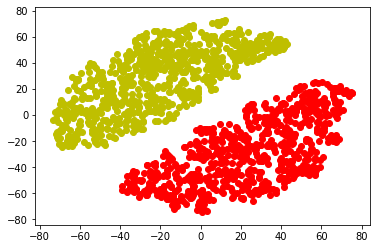

In [0]:
btime_start = time.time()
for j in range(0, 18):
  tsne = np.load(os.path.join(synthetic_path, f'tsne_sparsity{j+1}.npy') )
  y_pred_train = np.load(os.path.join(synthetic_path, f'kmeans_preds_sparsity{j}.npy') )
  for i in range(len(tsne)):
    plt.scatter(tsne[i][0], tsne[i][1], c=colors[int(y_pred_train[i].item())]) 
    if(i%250==0):
      print('.', end = '')
  del tsne
  del y_pred_train
  print(f'done. Time collapsed ={time.time()-time_start}')
  plt.title(f'Visualization against the KMeans Prediction for Sparsity = {j+1}')
  plt.savefig(os.path.join(kmeans_path,f'predictedKMeans_for_Sparsity_{j+1}.png'))
  plt.clf()

In [0]:
y_pred_train = torch.from_numpy(y_pred_train).type(torch.ByteTensor)#.cuda()
accuracy = torch.mean((torch.from_numpy(y_pred_train).view(10002) == labels.view(10002)).type(torch.FloatTensor)).item()
print(f'Gaussian Mixture Model Accuracy = {(accuracy)*100:.2f}%')

Gaussian Mixture Model Accuracy = 5.10%


In [0]:
uni = sparse()
(uni[90:96])

torch.Size([39, 1])


tensor([[-1.4063e-01, -2.8145e-01,  4.4411e-01,  5.8321e-02, -2.1524e-01,
          8.6211e-02, -1.0329e-01,  1.2181e-01,  7.2102e-01, -2.8954e-01,
          1.5922e-02,  1.0000e+00,  2.3463e-02, -4.5925e-02, -5.2821e-02,
          3.5522e-01, -1.6904e-04, -4.1855e-01,  1.2959e-01,  3.0241e-01,
         -1.7134e-01, -2.2824e-01, -2.7596e-01, -1.2453e-01, -9.1200e-02,
          1.3983e-01, -2.4867e-01,  4.8624e-02, -1.4572e-01, -9.8532e-02,
          4.0182e-01,  1.1139e-01, -7.1844e-02, -2.2730e-01, -9.3280e-02,
         -6.3991e-01, -9.7520e-02, -3.8303e-01,  4.2248e-01],
        [-6.9391e-01,  3.8642e-01, -3.8027e-01, -4.3062e-01,  3.5098e-01,
         -5.5339e-01,  3.5102e-01, -2.6369e-01, -8.6607e-02, -1.0981e-01,
          2.5792e-01,  1.0000e+00, -1.0263e-01, -1.6609e-01,  2.7656e-01,
          1.4986e-01, -4.4353e-01, -2.9889e-01,  2.4021e-02, -6.1056e-01,
          5.3332e-03,  2.5645e-01,  2.4435e-01, -5.7948e-03, -5.7108e-01,
         -2.6533e-01,  2.5154e-01,  3.0417e-03, -1

## KMeans

In [0]:
kmodel = KMeans(n_clusters = 2, random_state = 42)
y_pred_train = None
time_means_start = time.time()
X = X.cpu()
kmeans = kmodel.fit(X)
print(f'KMeans completed. Time elapsed = {time.time()-time_means_start:.2f}s')
y_pred_train = kmeans.labels_
train_accuracy = torch.mean((torch.from_numpy(y_pred_train).view(10002) == labels.view(10002)).type(torch.FloatTensor)).item()
print(f'KMeans Accuracy = {train_accuracy*100:.2f}%')
print(f'Done time elapsed = {time.time()-time_means_start:.2f}s')

KMeans completed. Time elapsed = 0.18s
KMeans Accuracy = 5.10%
Done time elapsed = 0.18s


.....................................................................................................

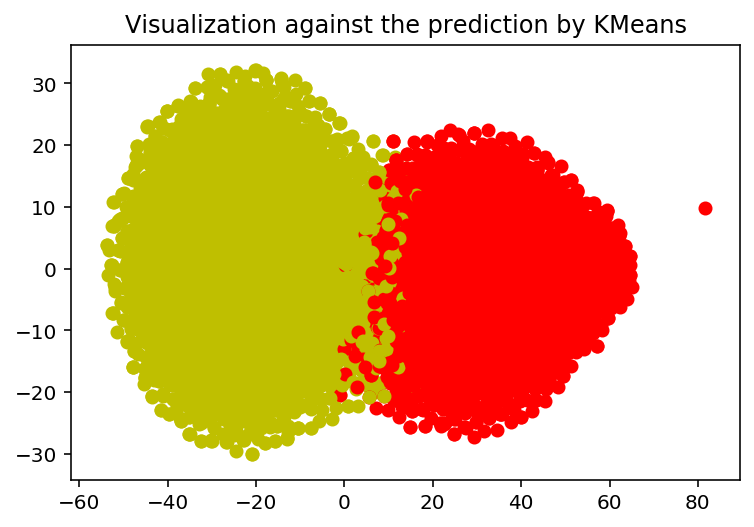

In [0]:
for i in range(len(tsne)):
  plt.scatter(tsne[i][0], tsne[i][1], c=colors[kmeans.labels_[i]])
  if(i%100==0):
    print('.', end = '')  
plt.title('Visualization against the prediction by KMeans')
plt.show()

## Autoencoder

In [0]:
class encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Sequential(nn.Linear(39, 2), 
                             nn.LogSoftmax(dim = 1))
  def forward(self, X):
    X = self.fc1(X)
    return X

In [0]:
class decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc2 = nn.Sequential(nn.Linear(2,39),
                             nn.Softmax(dim = 1))
  def forward(self, X):
    X = self.fc2(X)
    return X

In [0]:
class Autoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc
    self.dec = dec
  def forward(self, X):
    X = self.enc(X)
    X = self.dec(X)
    return X

In [0]:
enc = encoder()
dec = decoder()
autoencoder = Autoencoder(enc, dec)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

Autoencoder(
  (enc): encoder(
    (fc1): Sequential(
      (0): Linear(in_features=39, out_features=2, bias=True)
      (1): LogSoftmax()
    )
  )
  (dec): decoder(
    (fc2): Sequential(
      (0): Linear(in_features=2, out_features=39, bias=True)
      (1): Softmax(dim=1)
    )
  )
)

In [0]:
epochs = 600
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [0]:
X = X.to(device)

In [0]:
def train():
  
  autoencoder.train()
  train_loss = 0
  
  

  optimizer.zero_grad()

  X_p = autoencoder(X)

  loss = criterion(X_p, X)
  
  loss.backward()
  train_loss += loss.item()
  
  optimizer.step()
  return train_loss

In [0]:
def test():
  autoencoder.eval()
  test_loss = 0

  with torch.no_grad():

    X_p = autoencoder(X)

    loss = criterion(X_p, X)

    test_loss += loss.item()
  return test_loss

In [0]:
train_loss_list = []
# test_loss_list = []
time_start = time.time()
for e in range(epochs):
  
  train_loss = train()
  train_loss /= len(X)
  print(f'Training done. Time Collapsed = {time.time() - time_start: .2f}s')
  # print(f'Testing..')
  # test_loss = test()
  # test_loss /= len(val_data)
  # print(f'Testing done. Time Collapsed = {time.time() - time_start: .2f}s')
  train_loss_list.append(train_loss)
  # test_loss_list.append(test_loss)

Training done. Time Collapsed =  0.00s
Training done. Time Collapsed =  0.01s
Training done. Time Collapsed =  0.01s
Training done. Time Collapsed =  0.01s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.02s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.03s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.04s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Collapsed =  0.05s
Training done. Time Colla

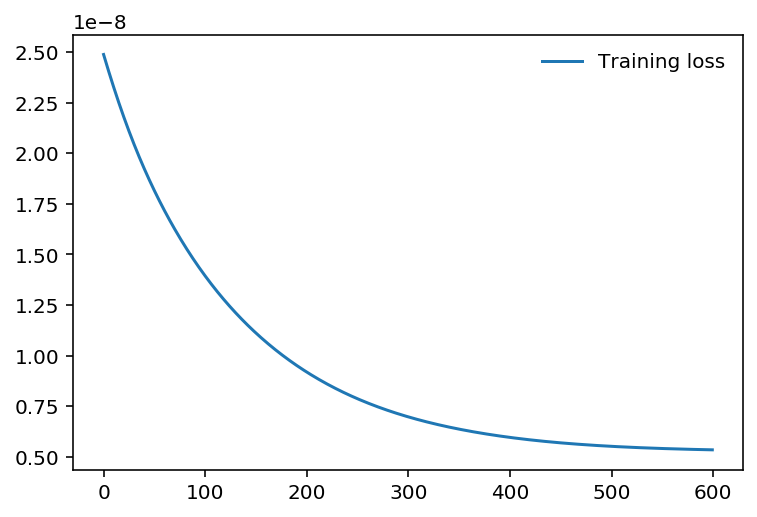

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_loss_list, label='Training loss')
# plt.plot(test_loss_list, label='Validation loss')
plt.legend(frameon=False)

done time elapsed = 63.44s


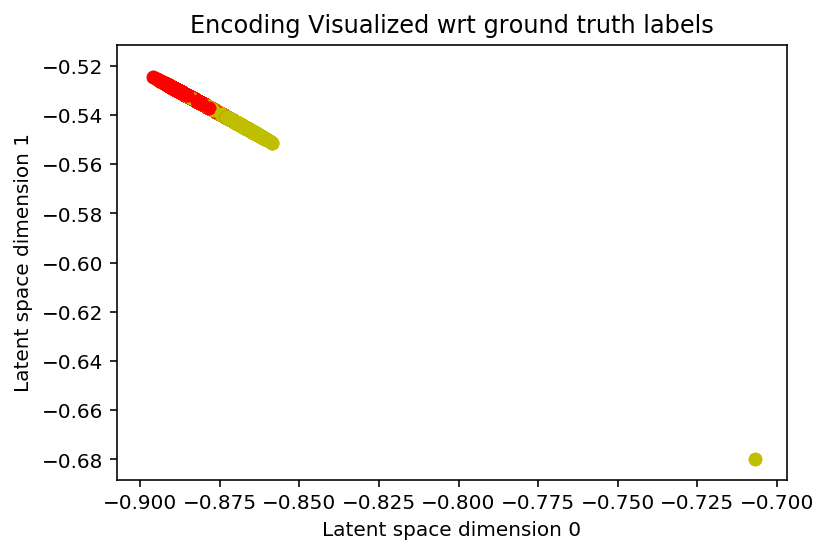

In [0]:
with torch.no_grad():
  enc.eval()
  enc.to(device)
  time_embedding = time.time()
  
  z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  z = z.cpu()
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(labels[i][0].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt ground truth labels')
  plt.show()

In [0]:
y_pred = torch.argmax(z.type(torch.LongTensor), dim = 1)
a = 1 - y_pred.type(torch.ByteTensor).cpu()
labels = labels.cpu()
accuracy = torch.mean((y_pred==labels).type(torch.FloatTensor))
print(f'accuracy = {(accuracy/len(X)*100):.3f}%')

accuracy = 0.005%


In [0]:
1/torch.mean(a.type(torch.FloatTensor))

tensor(10002.)

In [0]:
torch.mean(y_pred.type(torch.FloatTensor))

tensor(0.9999)

done time elapsed = 61.51s


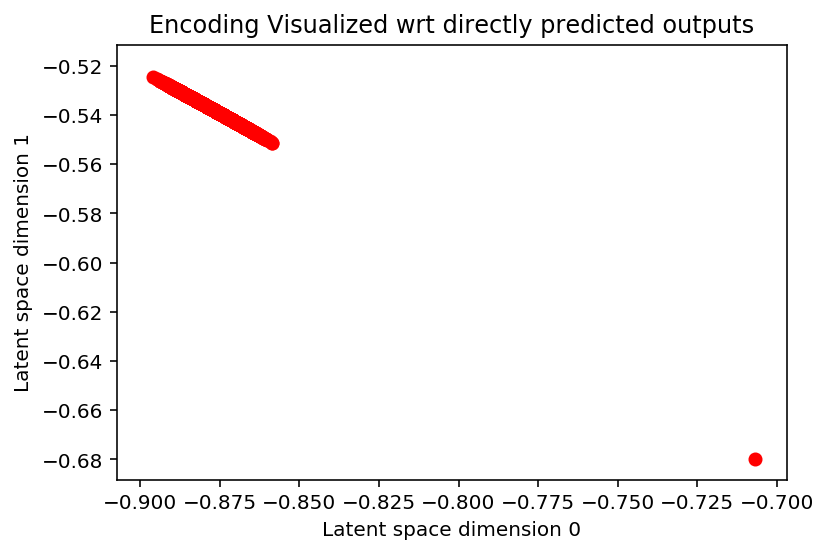

In [0]:
with torch.no_grad():
  # enc.eval()
  # enc.to(device)
  time_embedding = time.time()

  # z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(y_pred[i].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt directly predicted outputs')
  plt.show()

In [0]:
z.shape

torch.Size([10002, 2])

done time elapsed = 60.27s


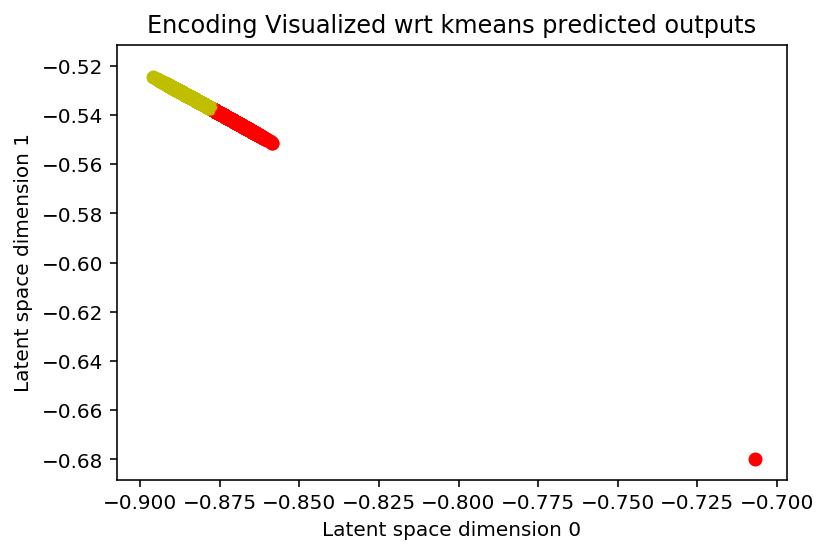

In [0]:
kmeans_auto =  KMeans(n_clusters = 2, random_state = 42)
km = kmeans_auto.fit(z)
kmeans_pred_label = km.labels_
with torch.no_grad():
  # enc.eval()
  # enc.to(device)
  time_embedding = time.time()

  # z = enc(X)    
  # std = torch.exp( z_var/2 ).cuda()
  # eps = torch.ones(std.shape).cuda()
  # z_sample = eps.mul(std).add_(z_mu)
  for i in range(len(X)):
    plt.scatter(z[i][0], z[i][1], c=colors[int(kmeans_pred_label[i].item())])
  print(f'done time elapsed = {time.time()-time_embedding:.2f}s')
  plt.xlabel('Latent space dimension 0')
  plt.ylabel('Latent space dimension 1')
  plt.title('Encoding Visualized wrt kmeans predicted outputs')
  plt.show()

In [0]:
train_accuracy = torch.mean((torch.from_numpy(kmeans_pred_label).view(10002) == labels.view(10002)).type(torch.FloatTensor)).item()
print(f'KMeans Accuracy on Encoding by Autoencoder = {train_accuracy*100:.2f}%')

KMeans Accuracy on Encoding by Autoencoder = 17.44%


In [0]:
np.mean((kmeans_pred_label==np.ones(kmeans_pred_label.shape)).astype('float32'))

0.5

In [0]:
kmeans_pred_label.shape

(10002,)

In [0]:
wrong_pred_list = []
for i in range(len(kmeans_pred_label)):
  if(kmeans_pred_label[i].item() != labels[i].item()): 
    wrong_pred_list.append(i)
    print(i)
print(len(wrong_pred_list))

10002


In [0]:
torch.sum((torch.from_numpy(kmeans_pred_label) == labels).type(torch.FloatTensor)).item()

50020000.0

In [0]:
zz = (torch.from_numpy(kmeans_pred_label).view(10002) == labels.view(10002))

In [0]:
kmeans_pred_label.shape

(10002,)

In [0]:
torch.mean(zz.type(torch.FloatTensor))

tensor(1.)

In [0]:
wrong_pred_list = []
for i,j in enumerate(zz):
  if (not j and (kmeans_pred_labels[i].item() != labels[i].item())):
    wrong_pred_list.append(i)
print(len(wrong_pred_list))

RuntimeError: ignored

In [0]:
zz.shape

torch.Size([10002])

In [0]:
for i,j in enumerate(zz):
  print(j)
  if i >5:
    break


tensor([ True,  True, False,  ...,  True, False,  True])
tensor([ True,  True, False,  ...,  True, False,  True])
tensor([False, False,  True,  ..., False,  True, False])
tensor([ True,  True, False,  ...,  True, False,  True])
tensor([False, False,  True,  ..., False,  True, False])
tensor([False, False,  True,  ..., False,  True, False])
tensor([ True,  True, False,  ...,  True, False,  True])


In [0]:
a = torch.randint(low = 0, high = 2, size = (10002,))
b = a.numpy()
c = ((torch.from_numpy(b) == a).type(torch.FloatTensor))
print(c)

tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [0]:
c.shape

torch.Size([10002])

In [0]:
nn.Flatten()(labels).shape

torch.Size([10002, 1])

## VAE

In [0]:
class encoder_v(nn.Module):
  def __init__(self):
    super().__init__()
    self.mu = nn.Sequential(nn.Linear(39, 500),nn.ReLU(),
                            nn.Linear(500, 500), nn.ReLU(),
                             nn.Linear(500, 2000), nn.ReLU(),
                            nn.Linear(2000,2),nn.ReLU())
    self.var = nn.Sequential(nn.Linear(39, 500), nn.ReLU(),
                            nn.Linear(500, 500), nn.ReLU(),
                             nn.Linear(500, 2000), nn.ReLU(),
                            nn.Linear(2000,2),nn.ReLU())
  def forward(self, X):
    z_mu = self.mu(X)
    z_var = self.var(X)
    return z_mu, z_var

In [0]:
class decoder_v(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc2 = nn.Sequential(nn.Linear(2,2000),nn.ReLU(),
                             nn.Linear(2000, 500), nn.ReLU(),
                             nn.Linear(500, 500), nn.ReLU(),
                             nn.Linear(500, 39), nn.ReLU())                            
  def forward(self, X):
    X = self.fc2(X)
    return X

In [0]:
class VAutoencoder(nn.Module):
  def __init__(self, enc, dec):
    super().__init__()
    self.enc = enc
    self.dec = dec
  def forward(self, X):
    z_mu, z_var = self.enc(X)
    std = torch.exp( z_var/2 )
    eps = torch.randn_like(std)
    z_sample = eps.mul(std).add_(z_mu)
    X_predic = self.dec(z_sample)
    return X_predic, z_mu, z_var

In [0]:
enc_v = encoder_v()
dec_v = decoder_v()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vautoencoder = VAutoencoder(enc_v, dec_v).to(device)
optimizer = torch.optim.Adam(vautoencoder.parameters(), lr = 0.001)
criterion = nn.MSELoss()

In [0]:
sensitivity = 100
X = np.load(os.path.join(synthetic_path, f'X_sparsity_1_variance_{1/sensitivity:.2f}.npy'))
X = torch.Tensor(X)
X= X.to(device)

In [0]:
def train():
  
  vautoencoder.train()
  train_loss = 0
  

  optimizer.zero_grad()

  X_pred, z_mu, z_var = vautoencoder(X)

  recon_loss = criterion(X_pred, X)
  kl_loss = 0.5*( torch.sum( torch.exp(z_var) + z_mu**2 - 1.0 + z_var ) ) 
  loss = recon_loss + kl_loss

  loss.backward()
  train_loss += loss.item()
  
  optimizer.step()
  return train_loss

In [0]:
# def test():
#   vautoencoder.eval()
#   test_loss = 0

#   with torch.no_grad():

#     X_ped, z_mu, z_var = vautoencoder(images)

#     recon_loss = criterion(X, images)
#     kl_loss = 0.5*torch.sum(torch.exp(z_var)+ z_mu**2 - 1 + z_var)
#     loss = recon_loss + kl_loss

#     test_loss += loss.item()      
#   return test_loss

In [0]:
epochs = 30

In [0]:
train_loss_list = []
test_loss_list = []
time_start = time.time()
for e in range(epochs):
  print(f'{e+1}th epoch...')
  print(f'Training...')
  train_loss = train()
  train_loss /= len(X)
  print(f'Training done. Time Collapsed = {time.time() - time_start: .2f}s')
  # print(f'Testing..')
  # test_loss = test()
  # test_loss /= len(val_data)
  # print(f'Testing done. Time Collapsed = {time.time() - time_start: .2f}s')
  train_loss_list.append(train_loss)
  # test_loss_list.append(test_loss)

1th epoch...
Training...
Training done. Time Collapsed =  0.20s
2th epoch...
Training...
Training done. Time Collapsed =  0.37s
3th epoch...
Training...
Training done. Time Collapsed =  0.54s
4th epoch...
Training...
Training done. Time Collapsed =  0.69s
5th epoch...
Training...
Training done. Time Collapsed =  0.84s
6th epoch...
Training...
Training done. Time Collapsed =  0.99s
7th epoch...
Training...
Training done. Time Collapsed =  1.14s
8th epoch...
Training...
Training done. Time Collapsed =  1.30s
9th epoch...
Training...
Training done. Time Collapsed =  1.44s
10th epoch...
Training...
Training done. Time Collapsed =  1.59s
11th epoch...
Training...
Training done. Time Collapsed =  1.74s
12th epoch...
Training...
Training done. Time Collapsed =  1.88s
13th epoch...
Training...
Training done. Time Collapsed =  2.03s
14th epoch...
Training...
Training done. Time Collapsed =  2.18s
15th epoch...
Training...
Training done. Time Collapsed =  2.33s
16th epoch...
Training...
Training

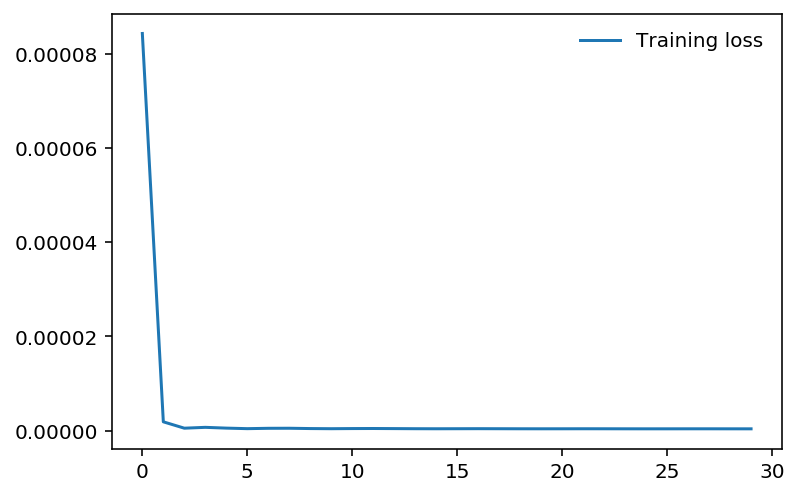

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_loss_list, label='Training loss')
plt.legend(frameon=False)

In [0]:
X.shape

torch.Size([10002, 39])

In [0]:
encoding,_ = enc_v(X)
encoding = encoding.cpu().detach()
encoding.shape


torch.Size([10002, 2])

In [0]:
labels = np.load(os.path.join(synthetic_path, f'labels_sparsity_1_variance_{1/sensitivity:.2f}.npy'))
labels = torch.Tensor(labels)

100%|██████████| 10002/10002 [01:28<00:00, 113.39it/s]


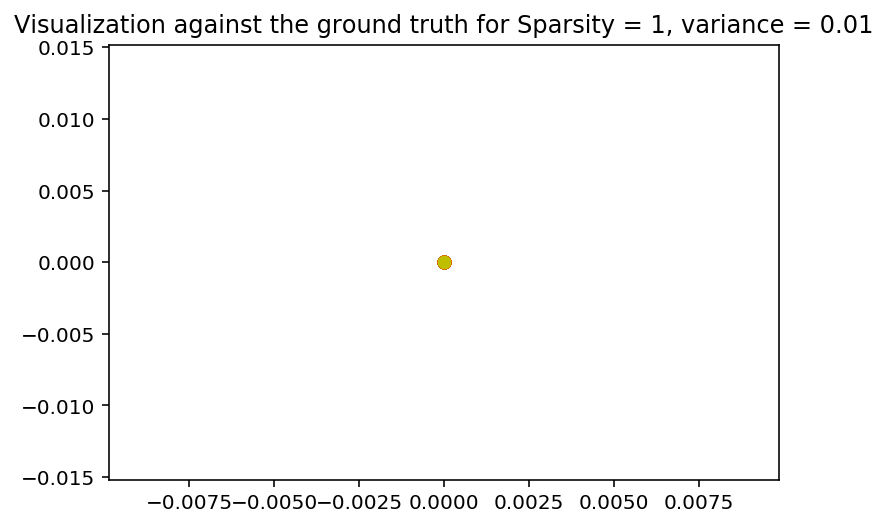

In [0]:
for i in tqdm(range(len(encoding))):
  plt.scatter(encoding[i][0], encoding[i][1], c=colors[int(labels[i].item())])  
plt.title(f'Visualization against the ground truth for Sparsity = 1, variance = {1/sensitivity:.2f}')
plt.savefig(os.path.join(synthetic_path,f'v_encoding_ground_truth_Sparsity_1_variance_{1/sensitivity:.2f}.png'))

# DEC

In [0]:

  autoencoder, encoder = autoencoder(dims, init=init)
  autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
  fits = autoencoder.fit(X, X, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
  # autoencoder.save_weights(os.path.join(synthetic_path, f"ae_sparsity_1_db_{db}.h5"))
  encoding = encoder.predict(X)
  # np.save(os.path.join(synthetic_path, f'encoding_sparsity_1_db_{db}.npy'), encoding) 
  #============#
  clustering_layer = ClusteringLayer(n_clusters = 2, name='clustering')(encoder.output)
  model = Model(inputs=encoder.input, outputs=clustering_layer)
  model.compile(optimizer=Adam(0.01), loss='kld')
  k_means = KMeans(n_clusters=2, n_init=20)
  y_pred_ae = k_means.fit_predict(encoding) 
  y_pred_last = np.copy(y_pred_ae)
  model.get_layer(name='clustering').set_weights([k_means.cluster_centers_])
  #===================#
  loss = 0
  index = 0
  maxiter = 8000
  update_interval = 140
  index_array = np.arange(X.shape[0])
  tol = 0.001 
  acc = 0
  #=====================#
  for ite in range(int(maxiter)):
      if ite % update_interval == 0:
          q = model.predict(X, verbose=0)
          p = target_distribution(q) 
          y_pred_ae = q.argmax(1)
          print(y_pred_ae.shape)
          print(labels.numpy().shape)
          if labels.numpy() is not None:
              acc = np.round(metrics.acc(labels.numpy().reshape(10002,), y_pred_ae), 5)
              nmi = np.round(metrics.nmi(labels.numpy().reshape(10002,), y_pred_ae), 5)
              ari = np.round(metrics.ari(labels.numpy().reshape(10002,), y_pred_ae), 5)
              loss = np.round(loss, 5)
              print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)
          delta_label = np.sum(y_pred_ae != y_pred_last).astype(np.float32) / y_pred_ae.shape[0]
          y_pred_last = np.copy(y_pred_ae)
          if ite > 0 and delta_label < tol:
              print('delta_label ', delta_label, '< tol ', tol)
              print('Reached tolerance threshold. Stopping training.')
              break
      idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
      loss = model.train_on_batch(x=X[idx], y=p[idx])
      index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0
  accuracy_dec_list.append(acc)
  # model.save_weights(os.path.join(synthetic_path, f'DEC_model_final_sparsity_1_db{db}.h5'))
  encoded_dec = encoder.predict(X)
  # np.save(os.path.join(synthetic_path, f'encoded_dec_sparsity_1_db_{db}.npy'), encoded_dec)
  # del encoding, loss, idx, index, model,acc,nmi, ari, clustering_layer, k_means, y_pred_last, delta_label, encoded_dec
  #===========================#

Epoch 1/30
10002/10002 [==============================] - 2s 174us/step - loss: 0.1020
Epoch 2/30
10002/10002 [==============================] - 1s 59us/step - loss: 0.0052
Epoch 3/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0050
Epoch 4/30
10002/10002 [==============================] - 1s 57us/step - loss: 0.0048
Epoch 5/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0050
Epoch 6/30
10002/10002 [==============================] - 1s 57us/step - loss: 0.0034
Epoch 7/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0027
Epoch 8/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0026
Epoch 9/30
10002/10002 [==============================] - 1s 59us/step - loss: 0.0031
Epoch 10/30
10002/10002 [==============================] - 1s 57us/step - loss: 0.0026
Epoch 11/30
10002/10002 [==============================] - 1s 58us/step - loss: 0.0025
Epoch 12/30
10002/10002 [==========================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 140: acc = 0.98170, nmi = 0.88624, ari = 0.92815  ; loss= 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


(10002,)
(10002, 1)
Iter 280: acc = 0.98130, nmi = 0.88433, ari = 0.92661  ; loss= 0.0
delta_label  0.0009998000399920016 < tol  0.001
Reached tolerance threshold. Stopping training.


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


<function matplotlib.pyplot.show>

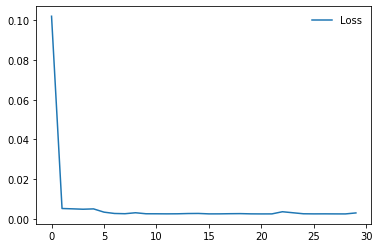

In [0]:
plt.plot(fits.history['loss'], label = 'Loss')
plt.legend(frameon = False)
plt.show